
Processing: jana_nerudová.parquet


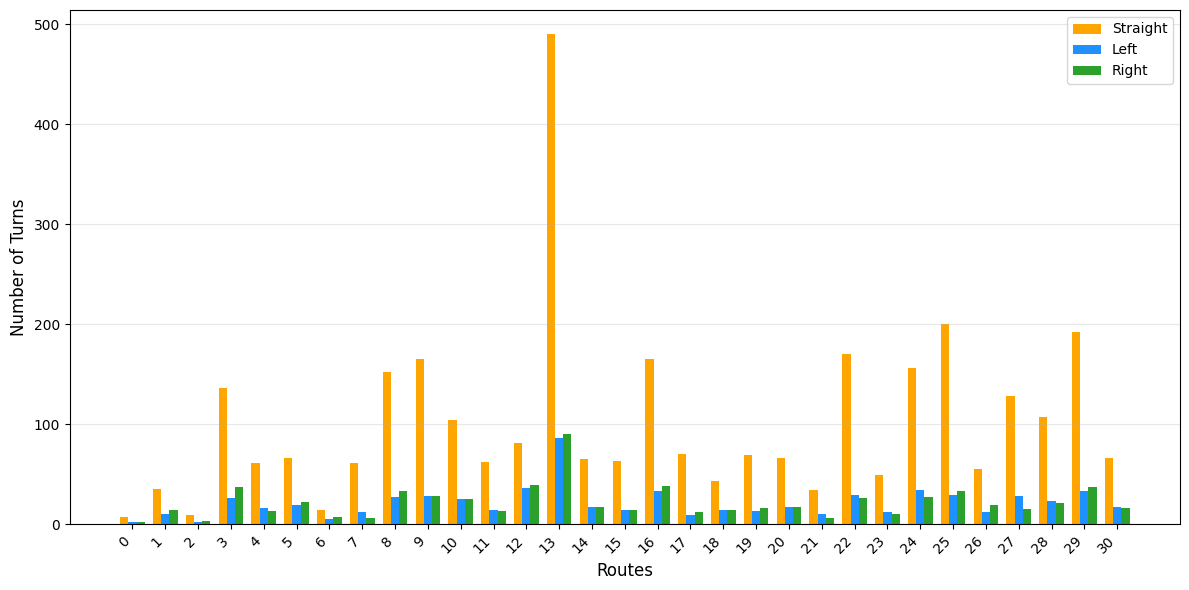


Processing: brad_stahlman.parquet


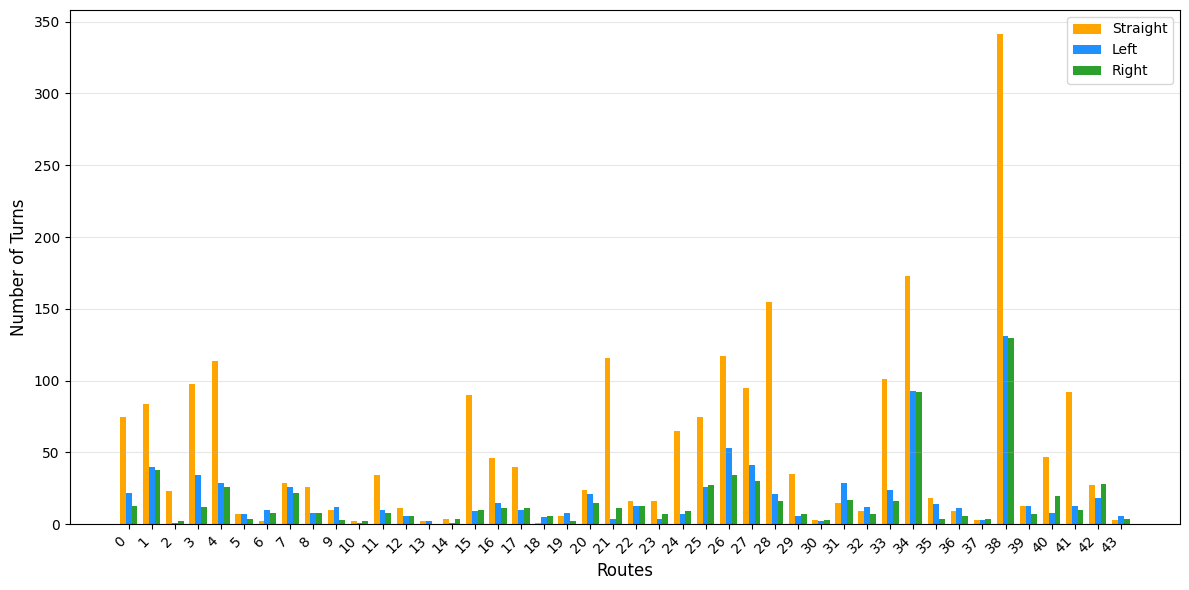


Processing: brian_watson.parquet


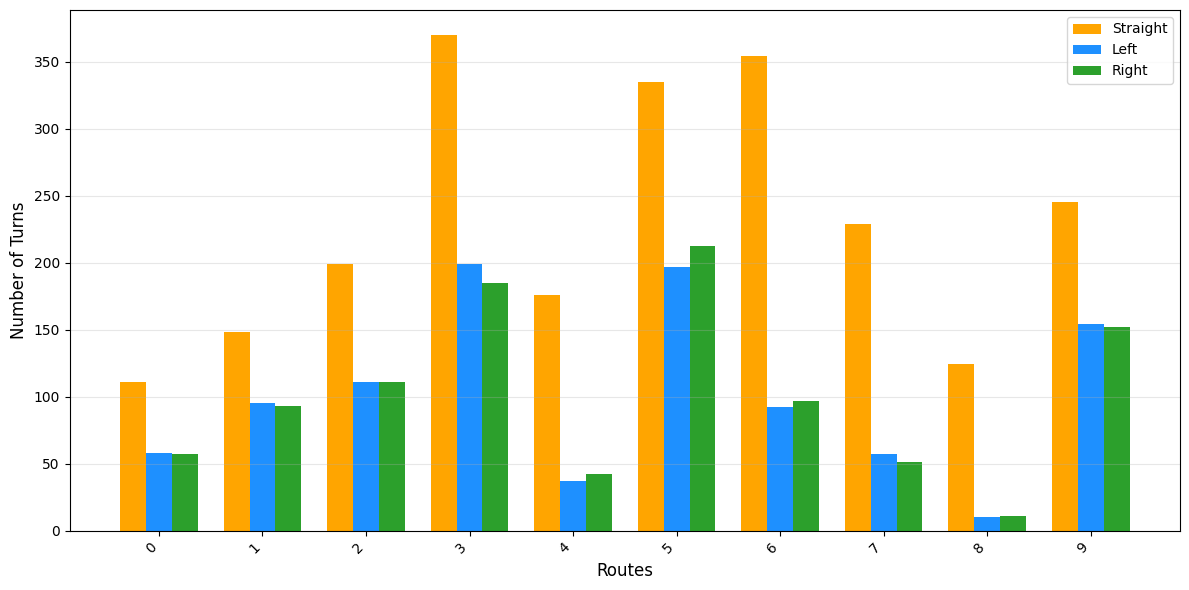


Processing: dennis_lindsay.parquet
No valid routes in dennis_lindsay.parquet

Processing: john_goss.parquet


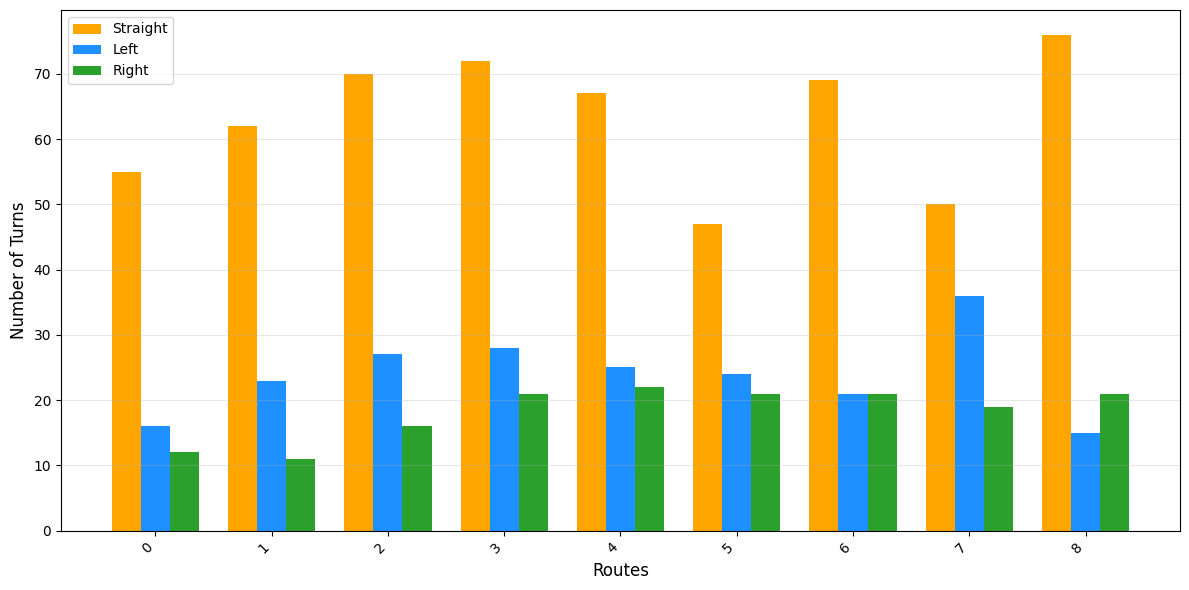


Processing: issy_nielson.parquet


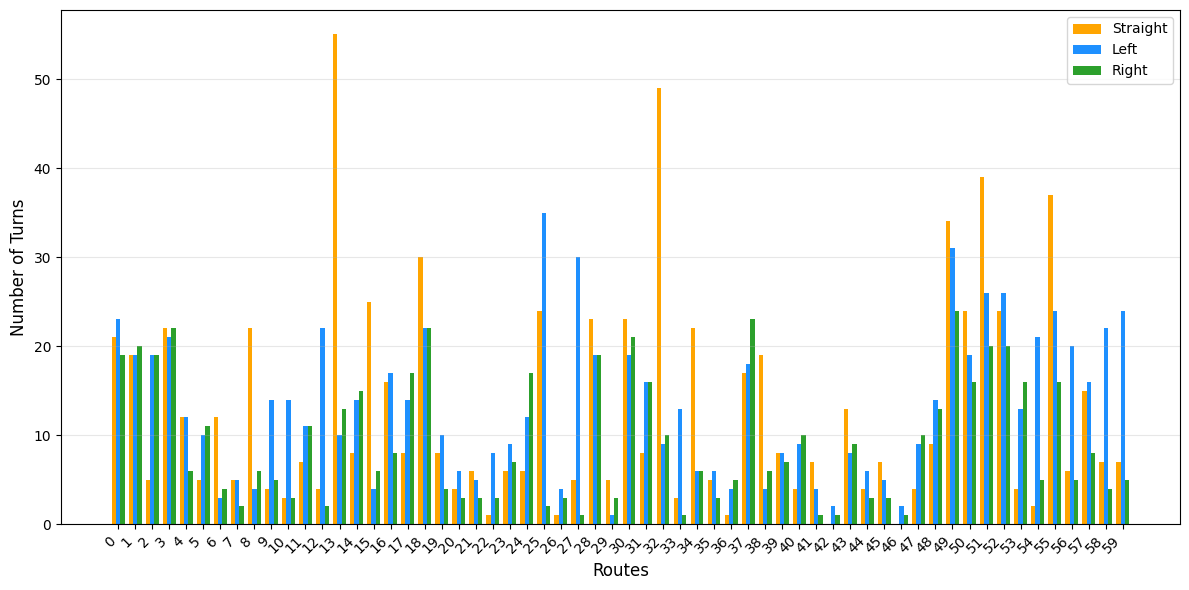


Processing: stefan_hornke.parquet


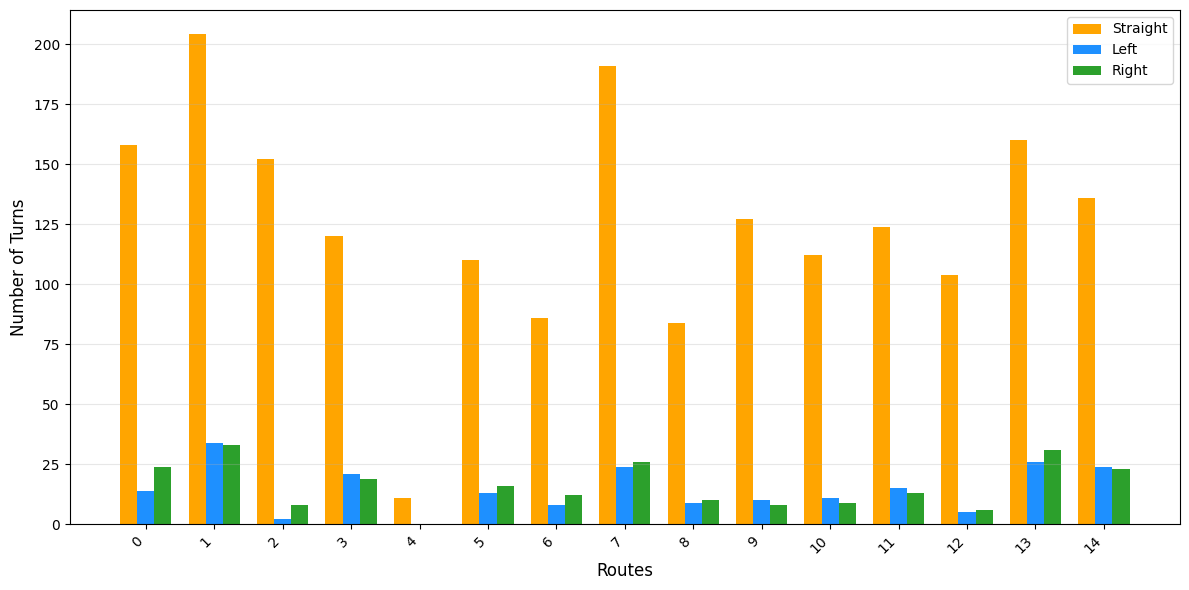


Processing: todd_baum.parquet


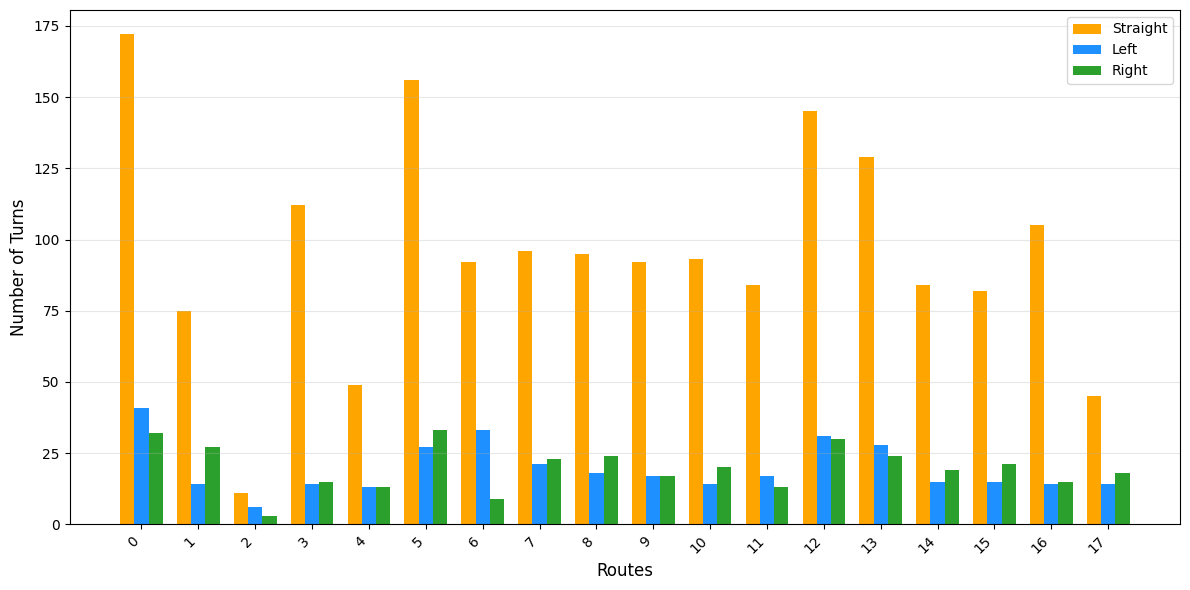


Processing: rhiannon_settles.parquet
No valid routes in rhiannon_settles.parquet

Processing: george_bella.parquet
No valid routes in george_bella.parquet

Processing: mollie_melton.parquet


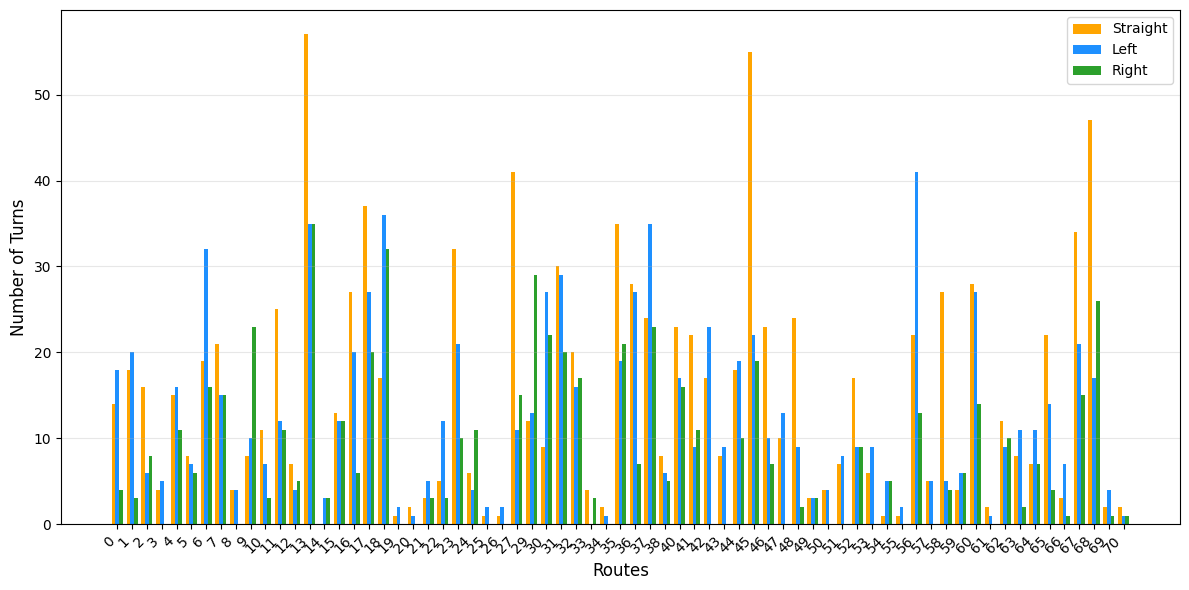


Processing: geraud_mousnier.parquet


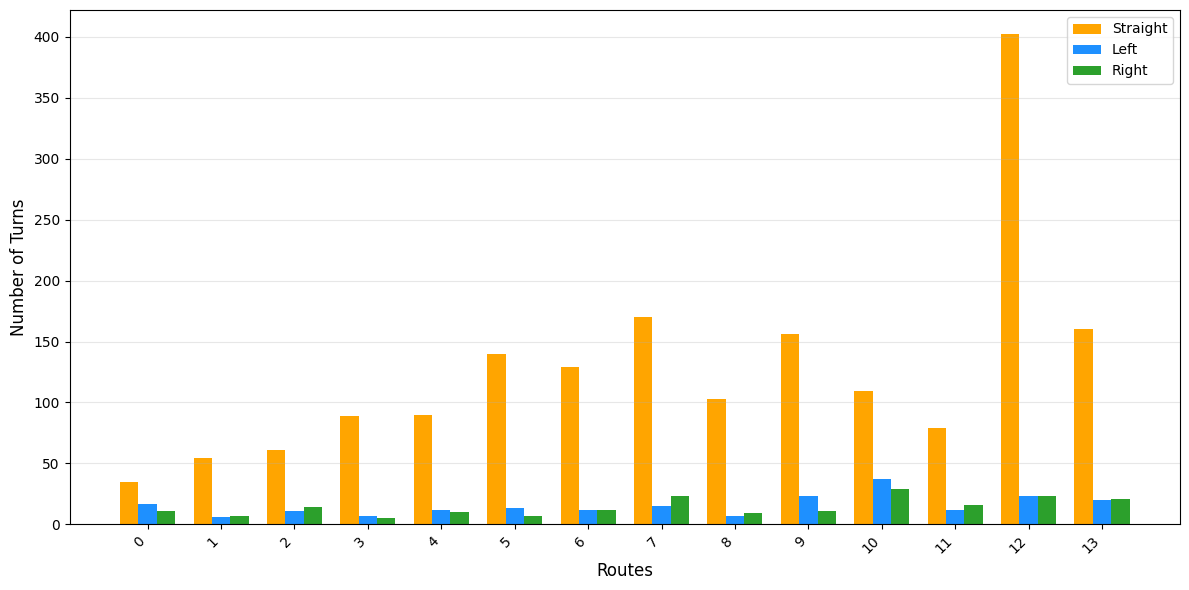


Processing: david_bunting.parquet
No valid routes in david_bunting.parquet

Processing: huggi_bayanbyamba.parquet


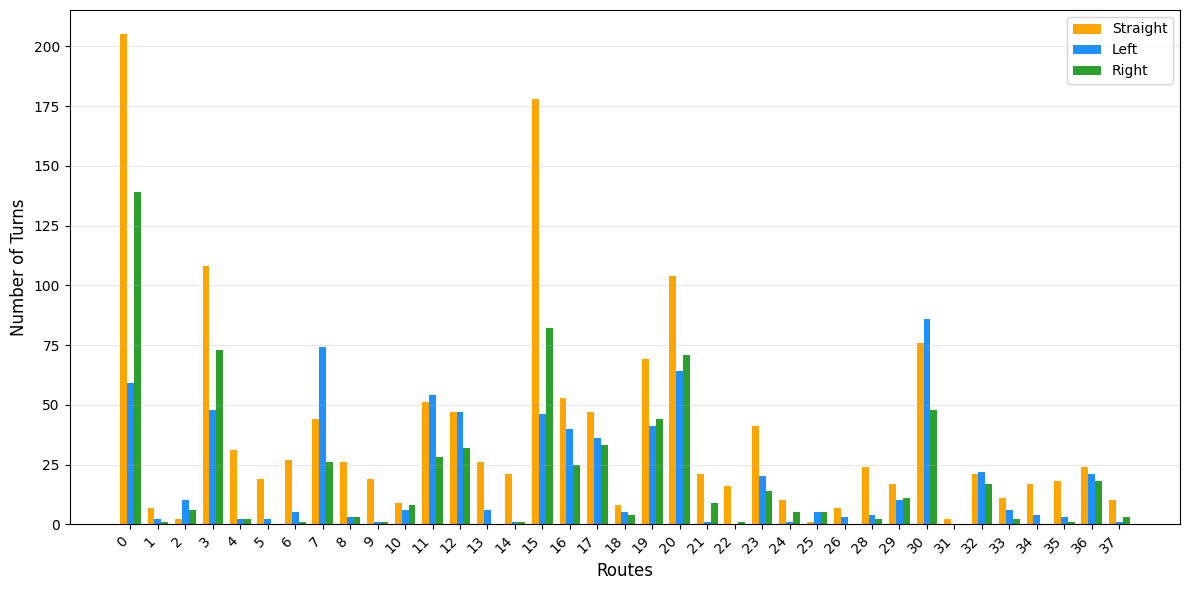


Processing: noah_white.parquet


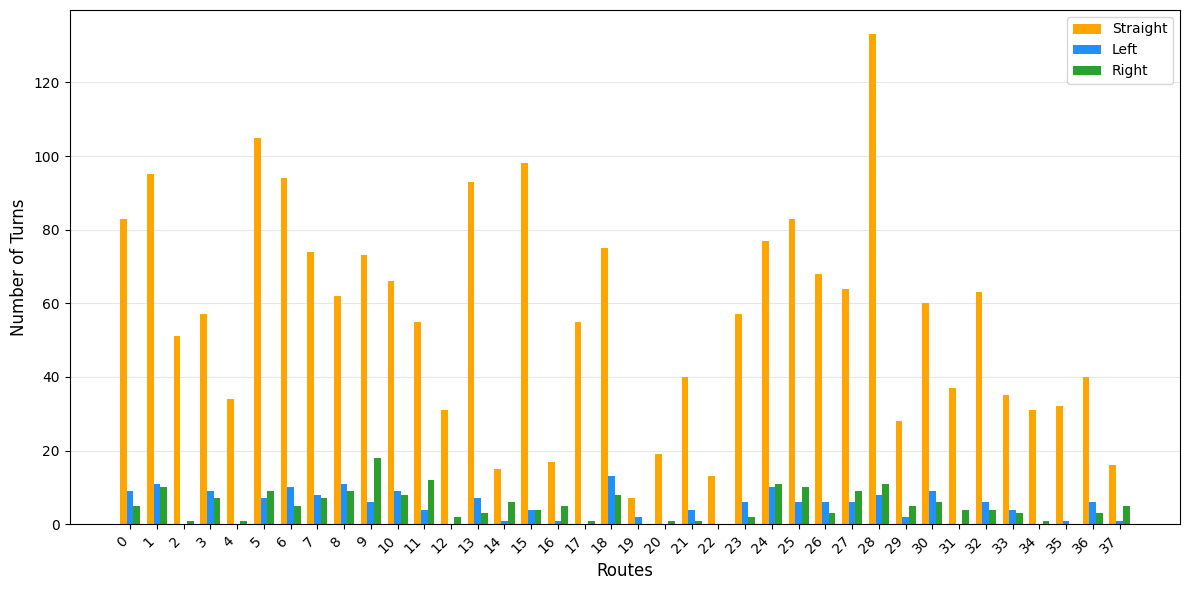


Processing: eileen_cohen.parquet


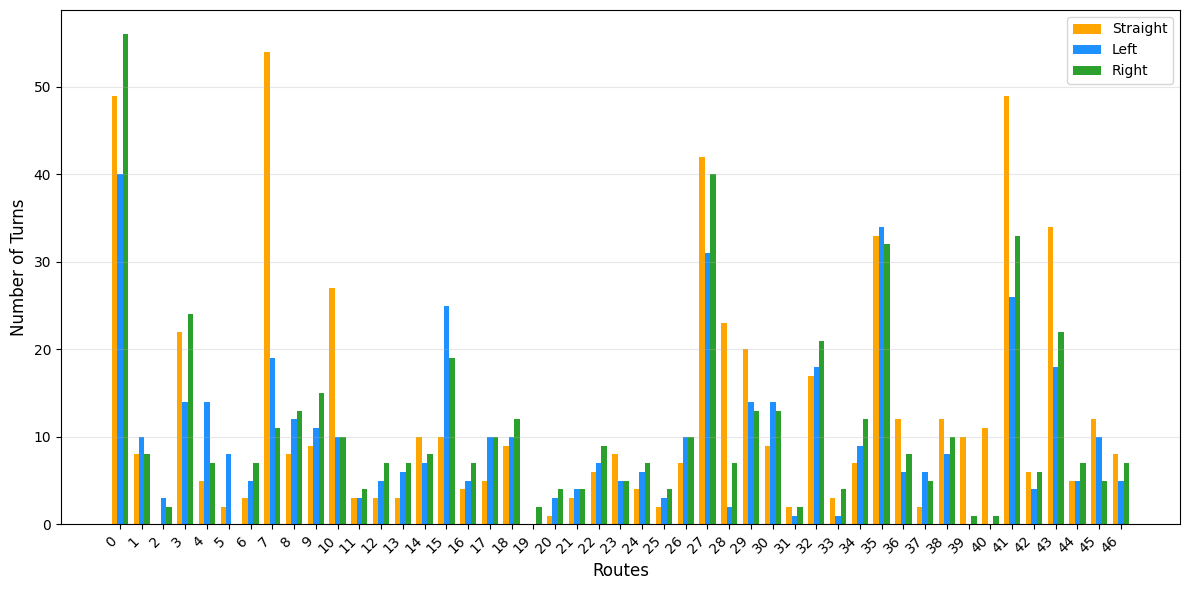


Processing: andre_tannemann.parquet


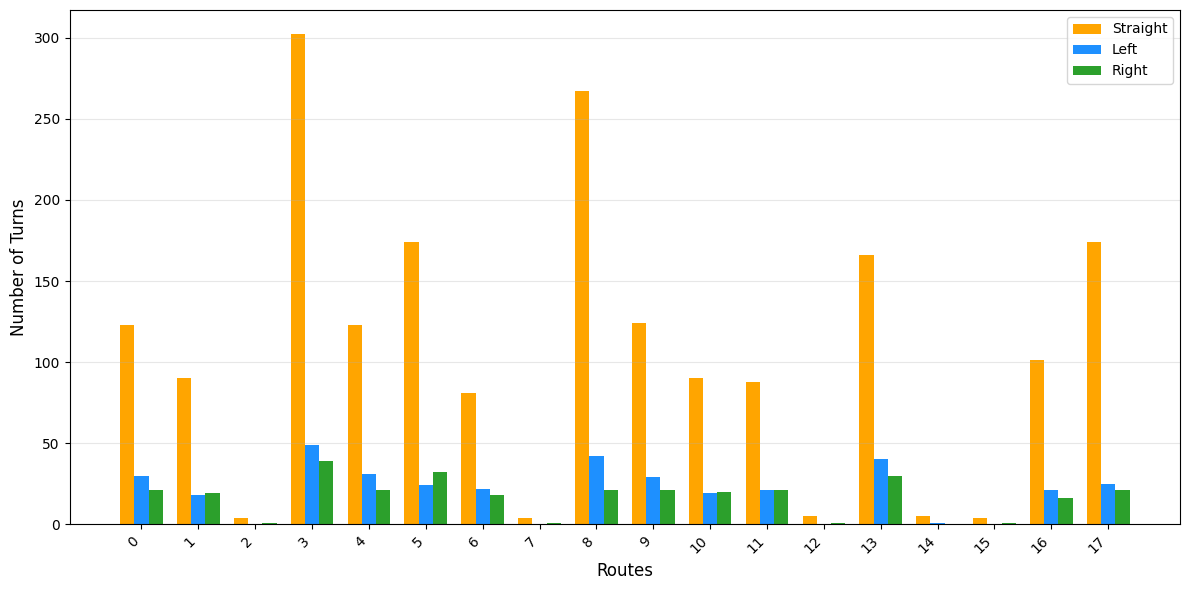


Processing: ken_kirsch.parquet


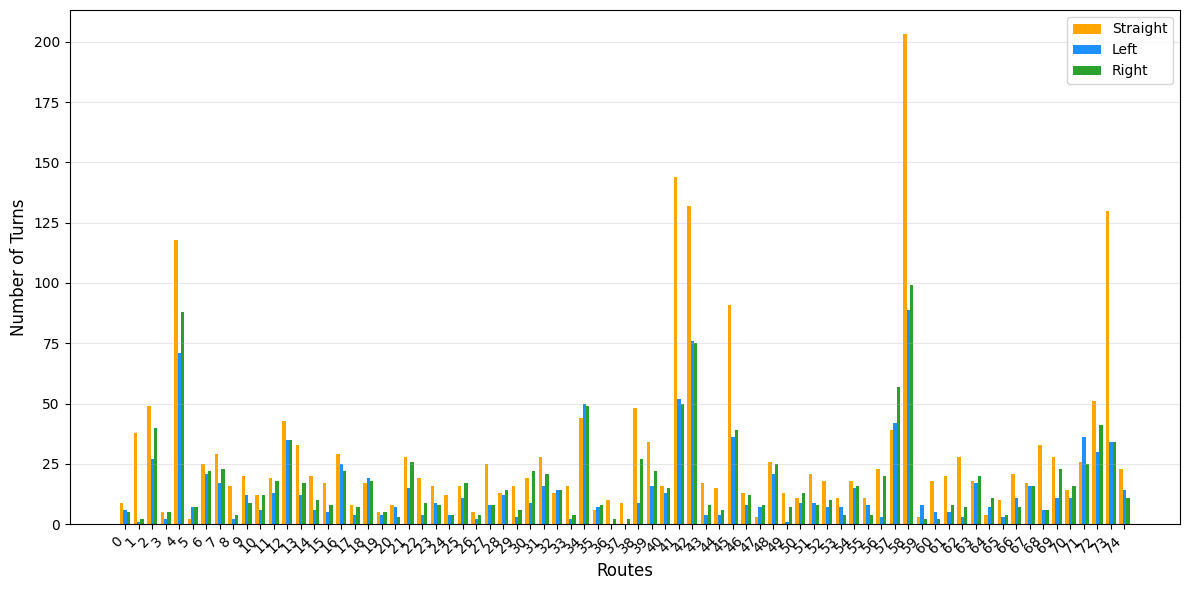


Processing: stuart_foster.parquet


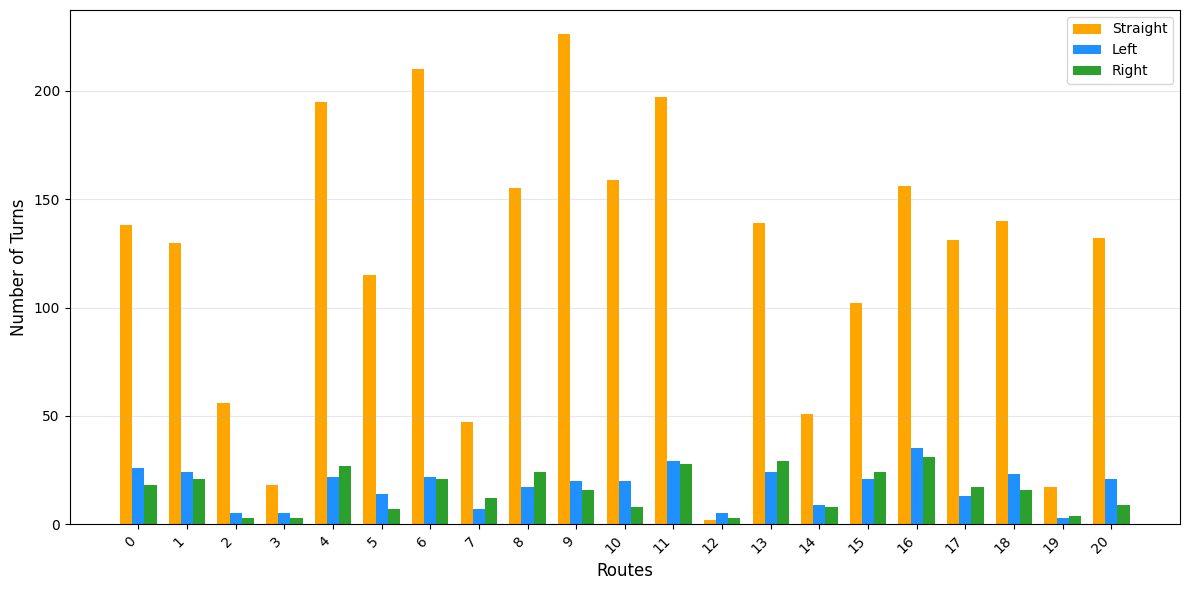


Processing: steve_schohn.parquet


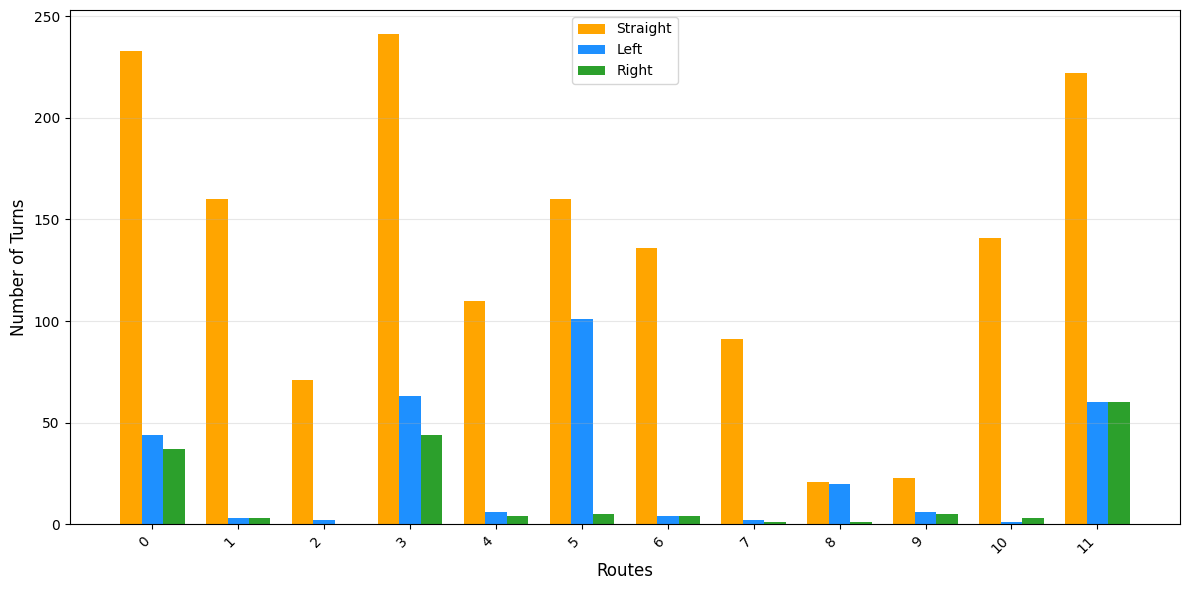


Processing: jen_cadenhead.parquet


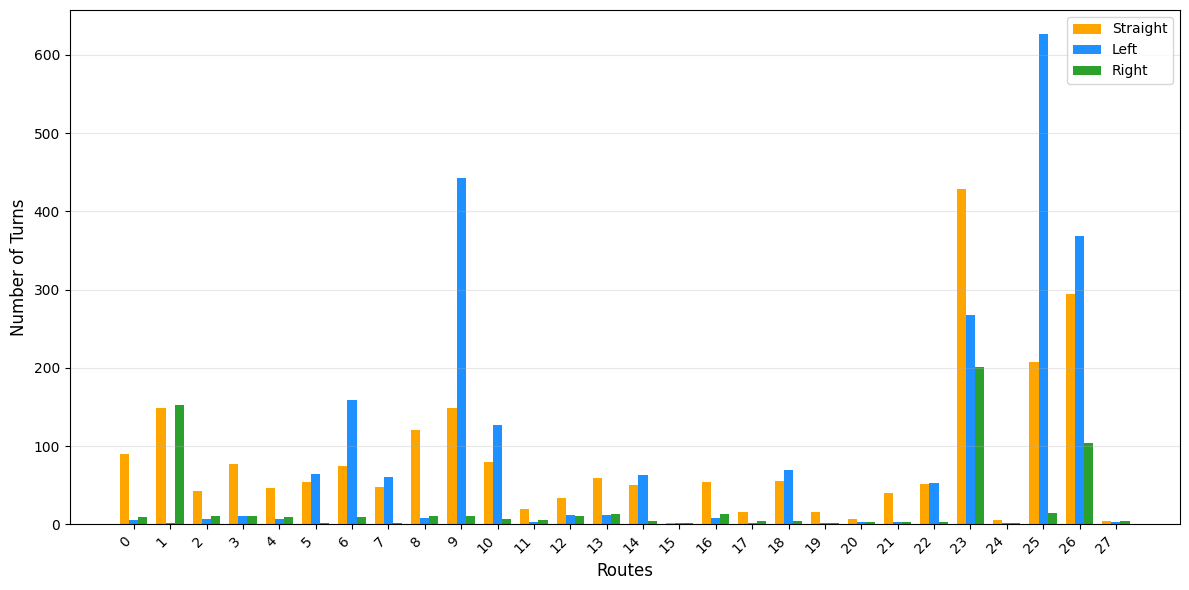


Processing: amy_pizer.parquet


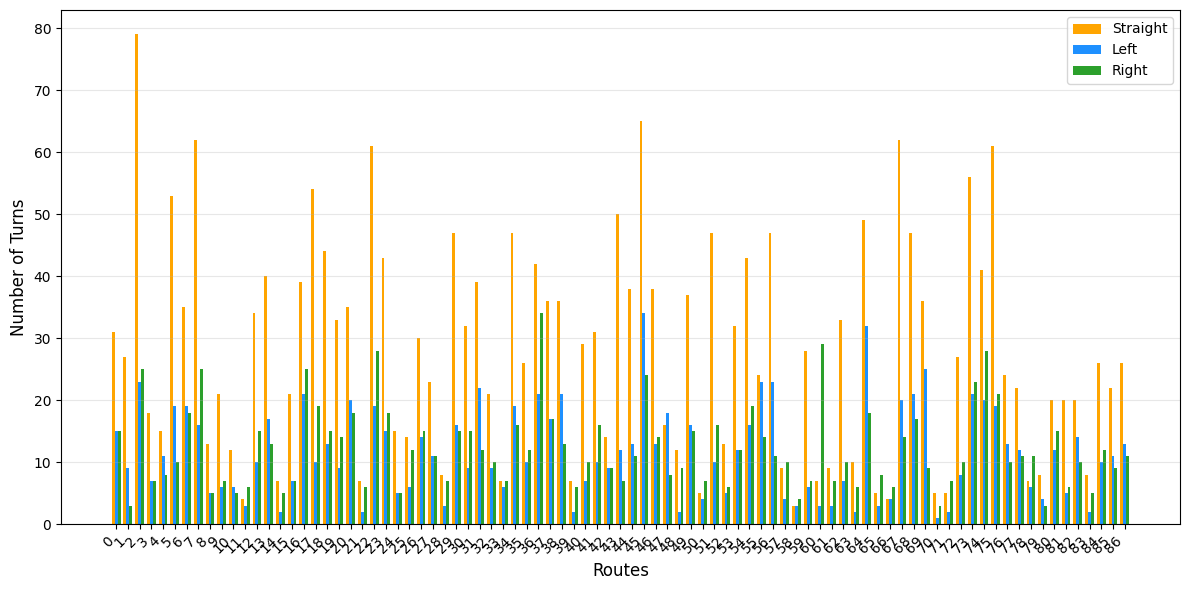


Processing: andrew_mccrory.parquet


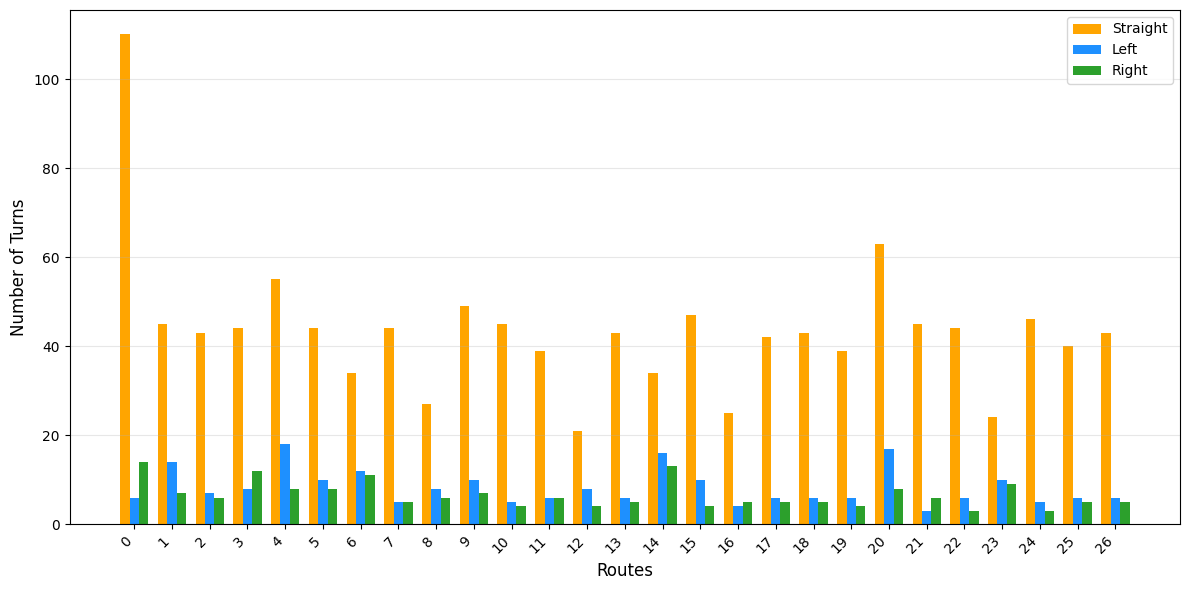


Processing: john_thayer.parquet
No valid routes in john_thayer.parquet

Processing: mark_bull.parquet


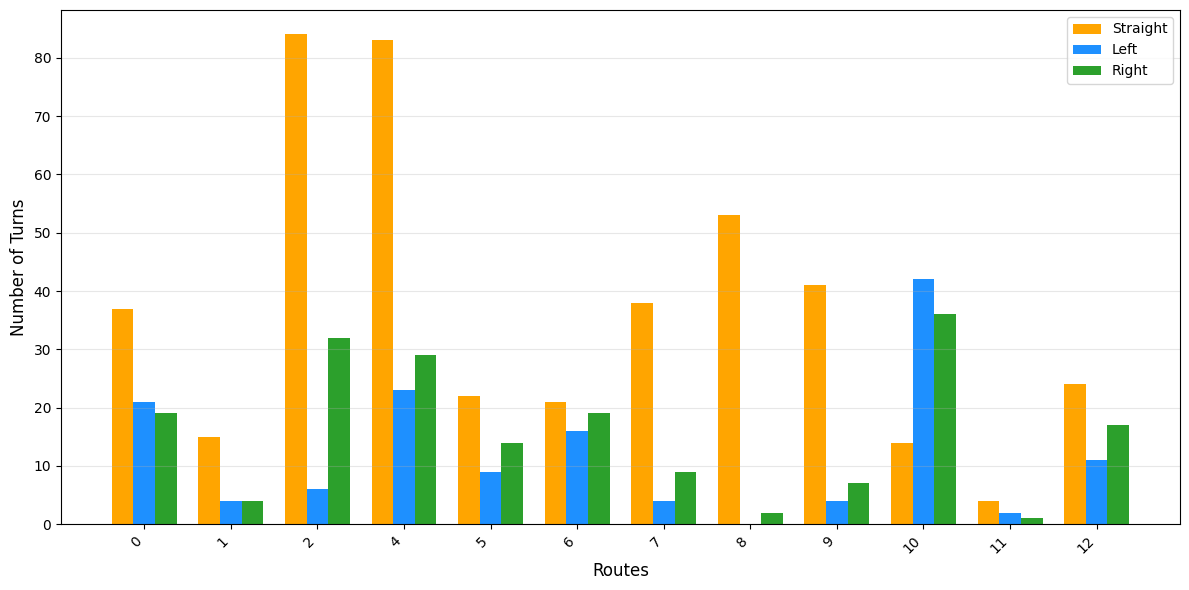


Processing: tom_weaver.parquet


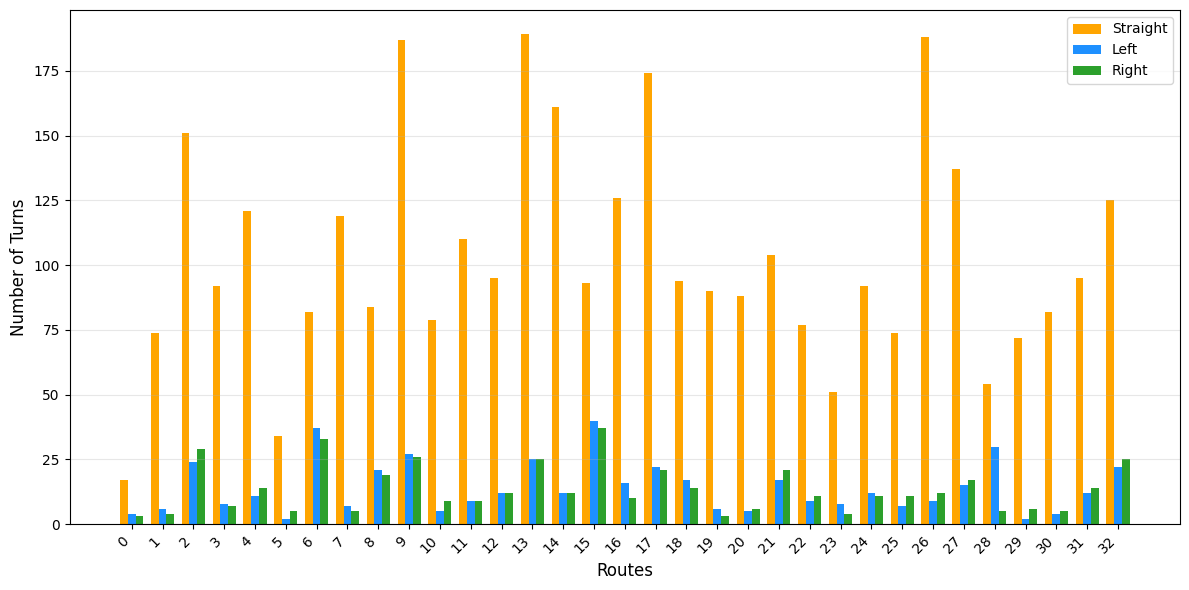


Processing: chris_calimano.parquet


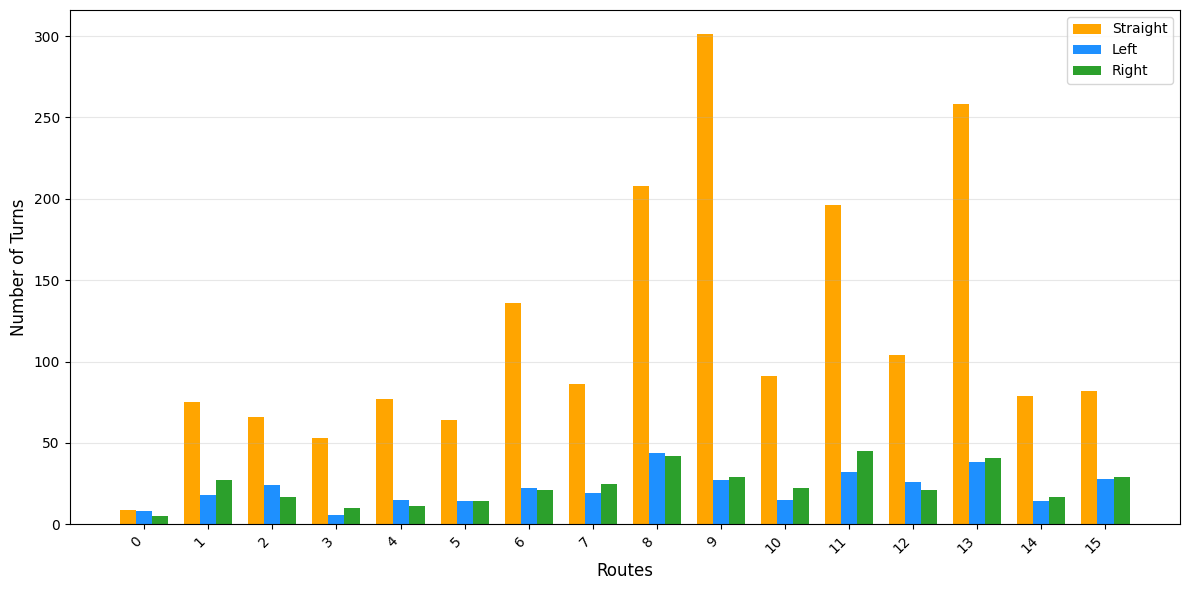


Processing: bethany_pribila.parquet


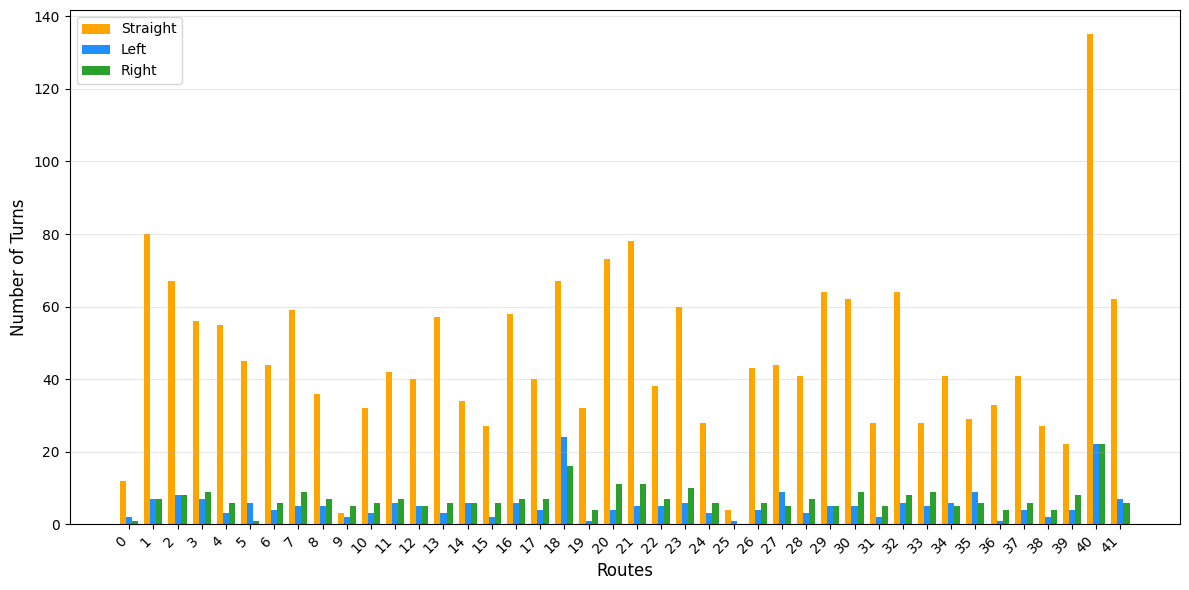


Processing: zeph_brand.parquet


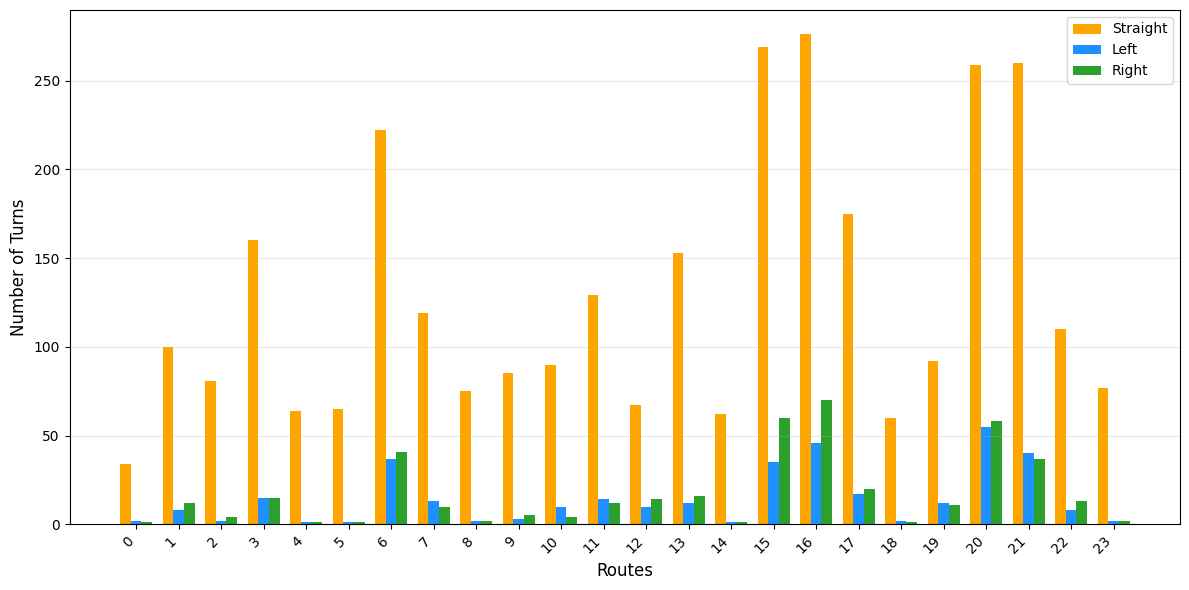


Processing: vera_stetinova.parquet


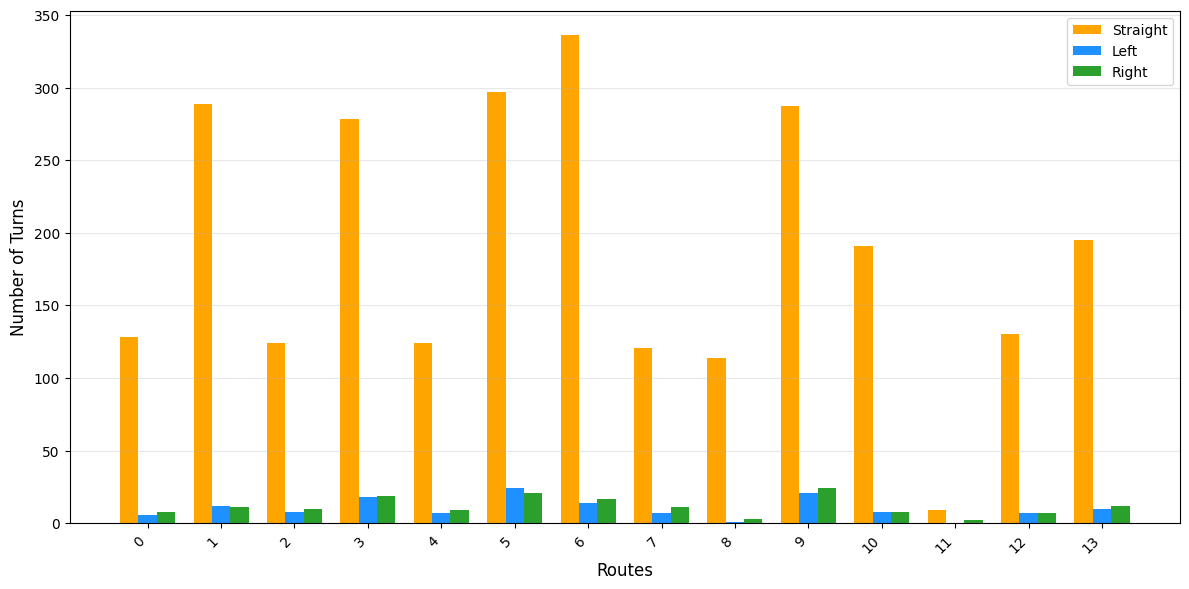


Processing: mathias_göbel.parquet


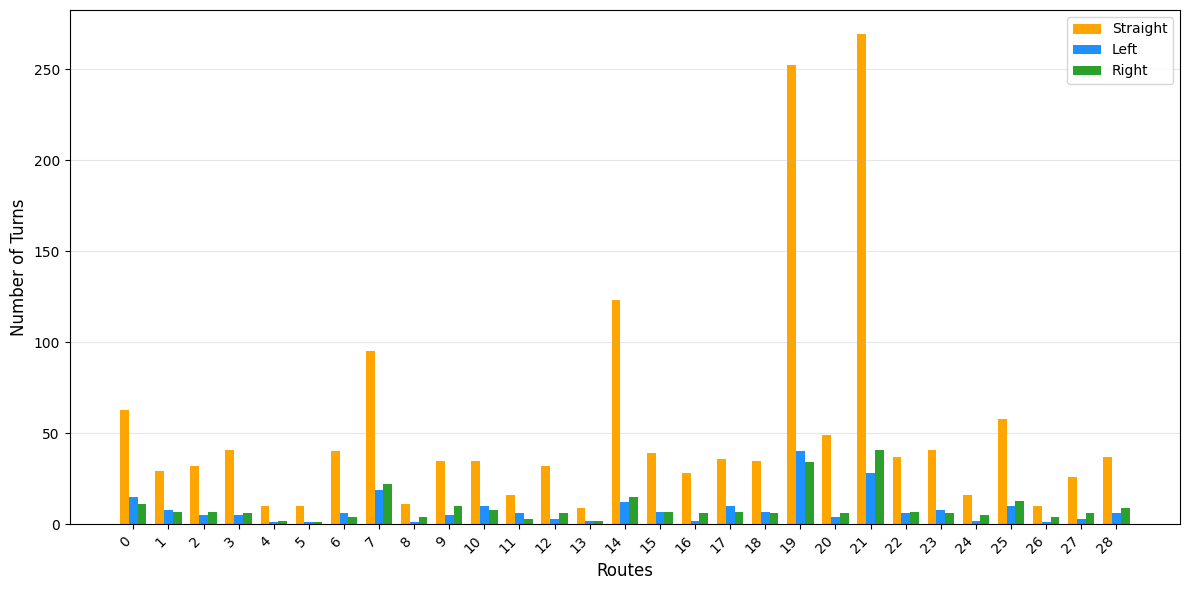


Processing: monique_barrant.parquet
No valid routes in monique_barrant.parquet

Processing: w_ford_graham.parquet


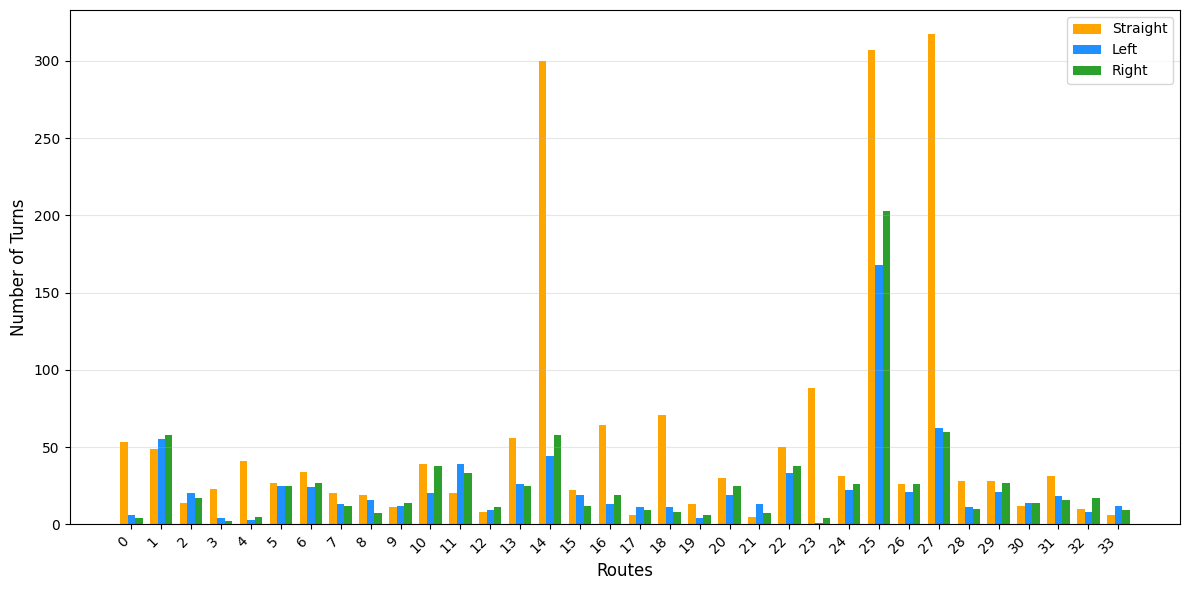


Processing: bryan_twomey.parquet


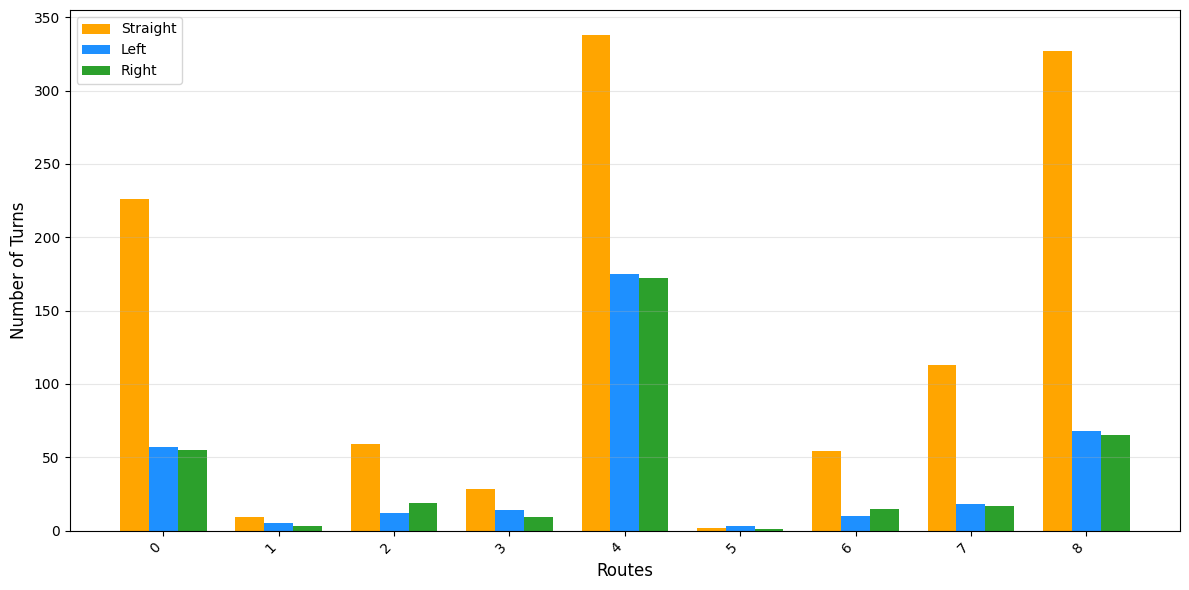


Processing: angela_chong.parquet


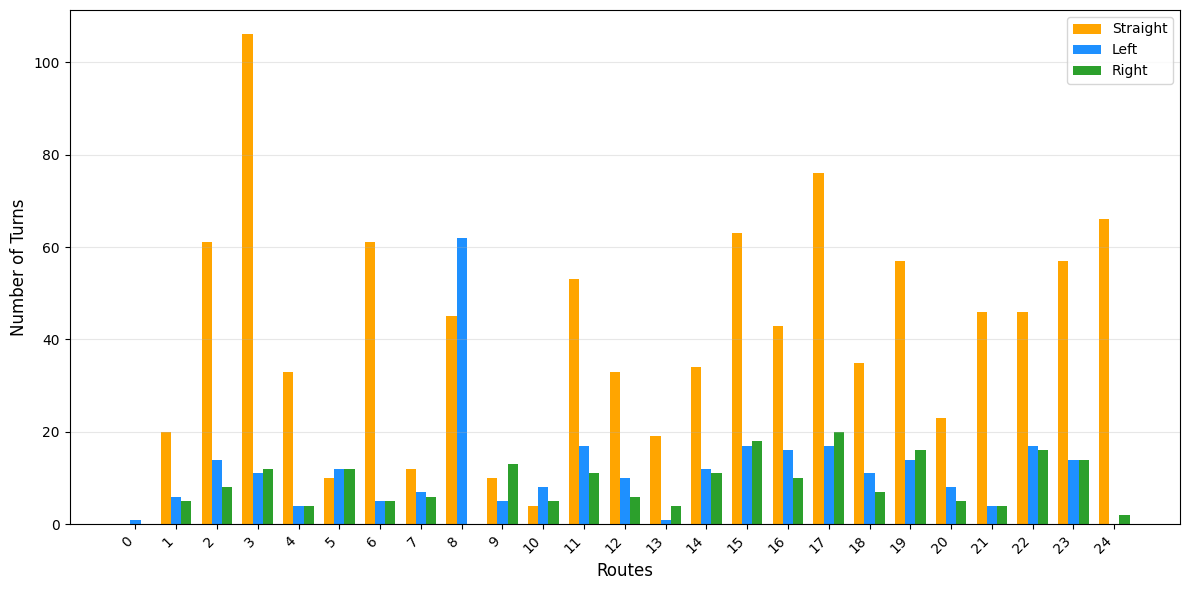


Processing: kevin_dockemeyer.parquet


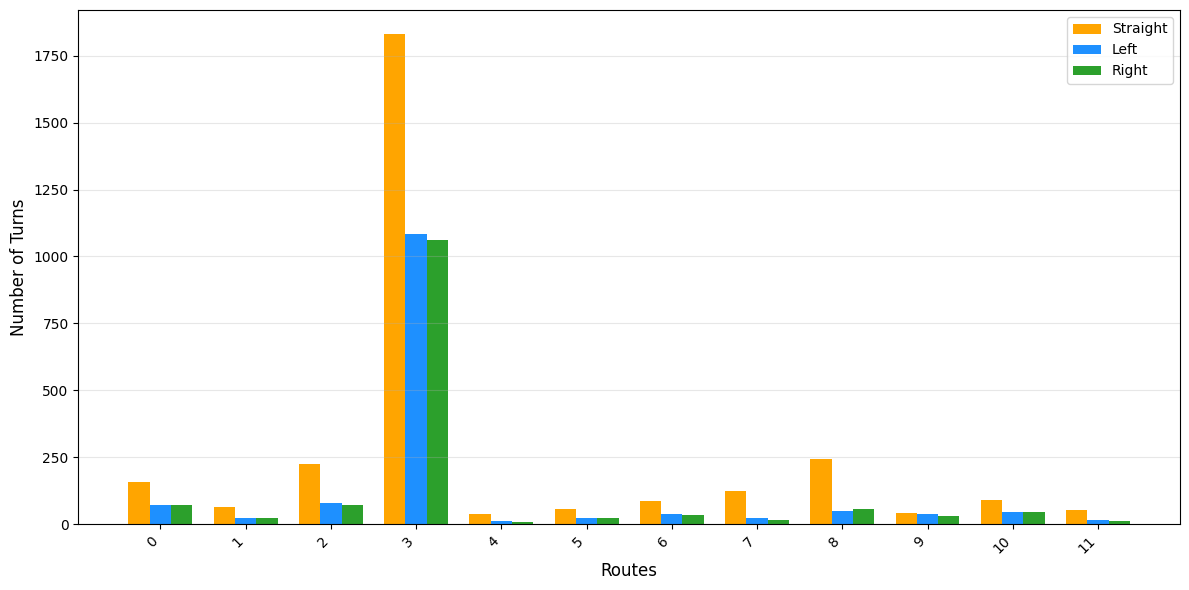


Processing: jeffrey_ruiz.parquet


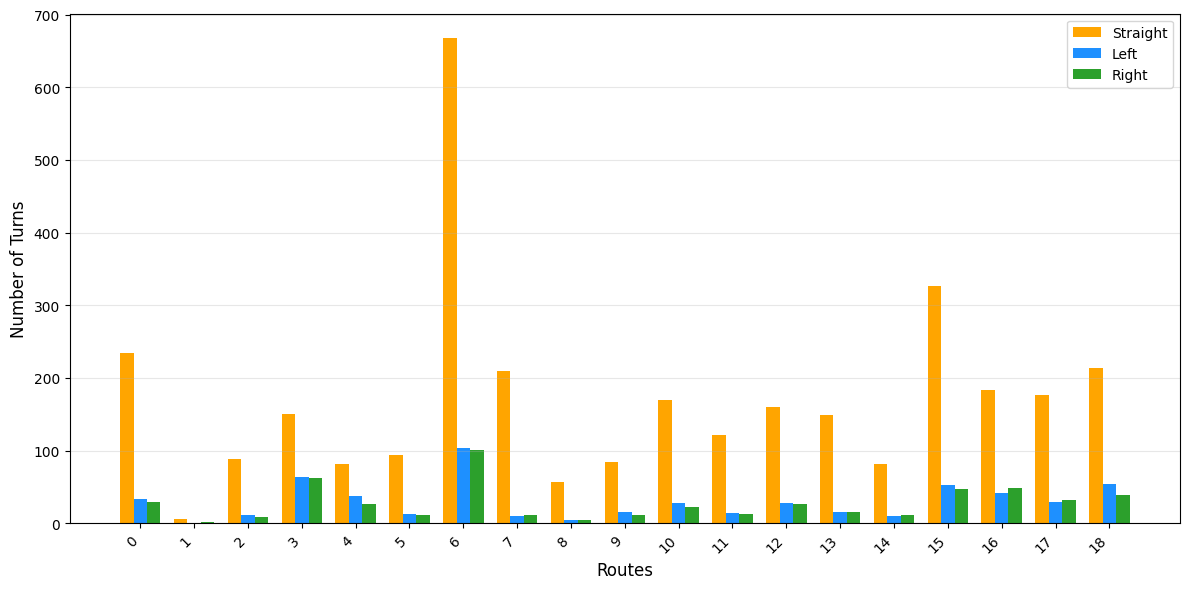


Processing: marc_sanderson.parquet


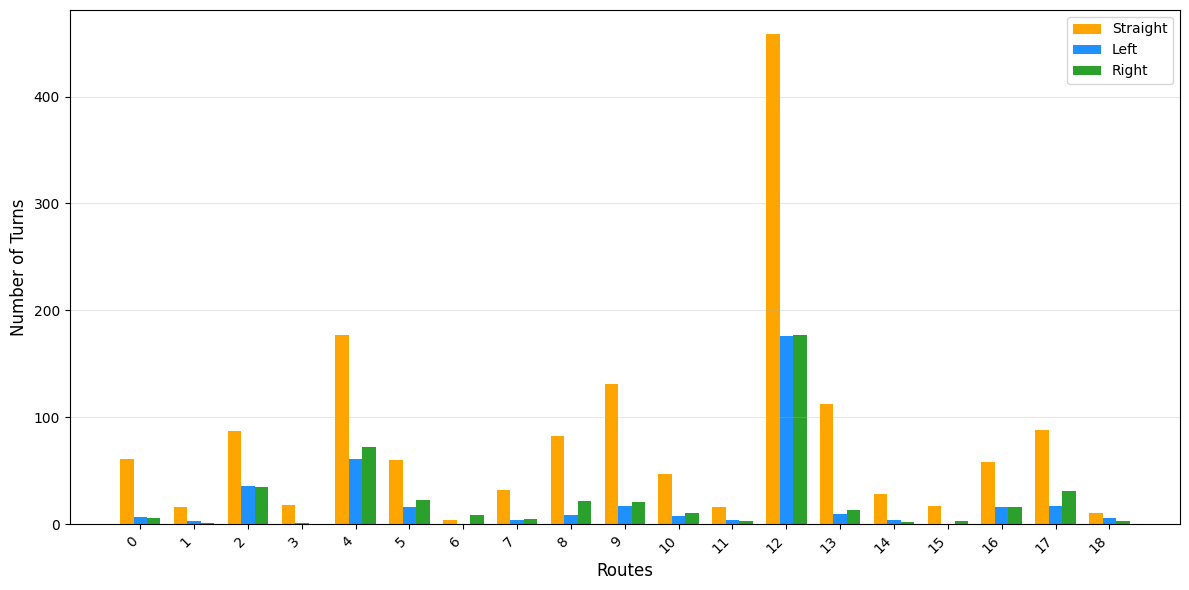


Processing: caryn_lubetsky.parquet


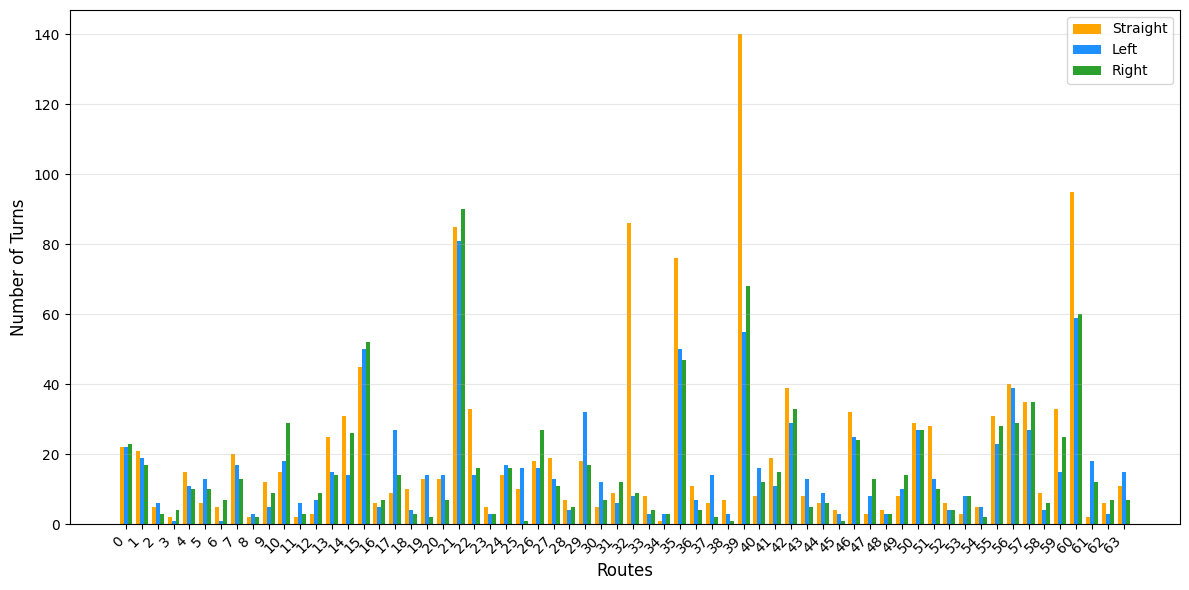


Processing: rhiannon_bramer.parquet


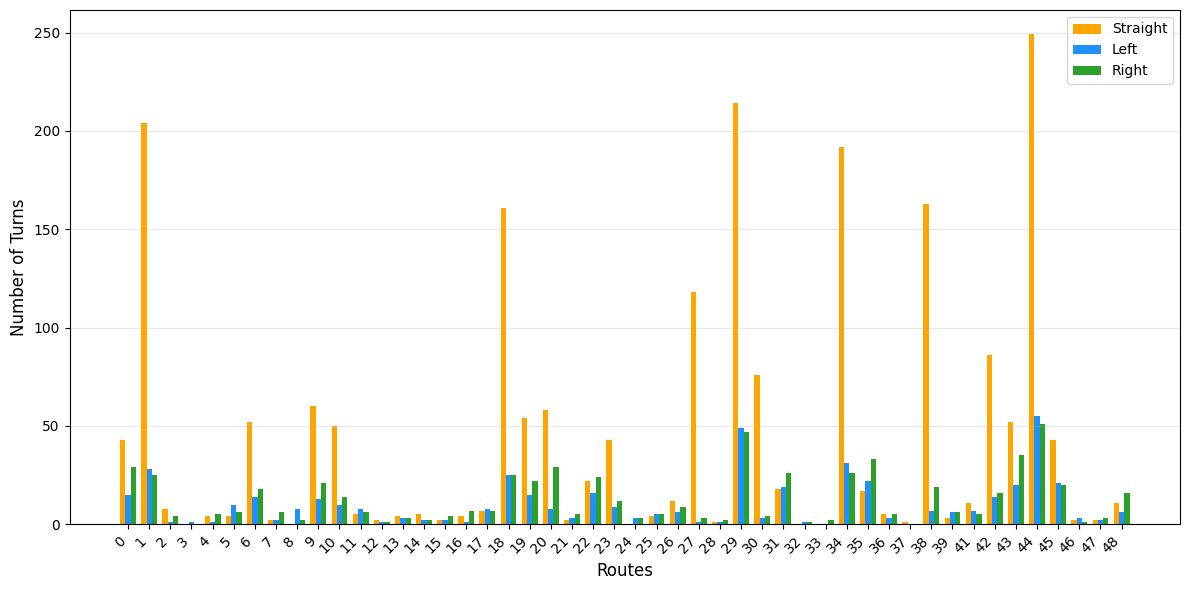


Processing: dani_grigsby.parquet


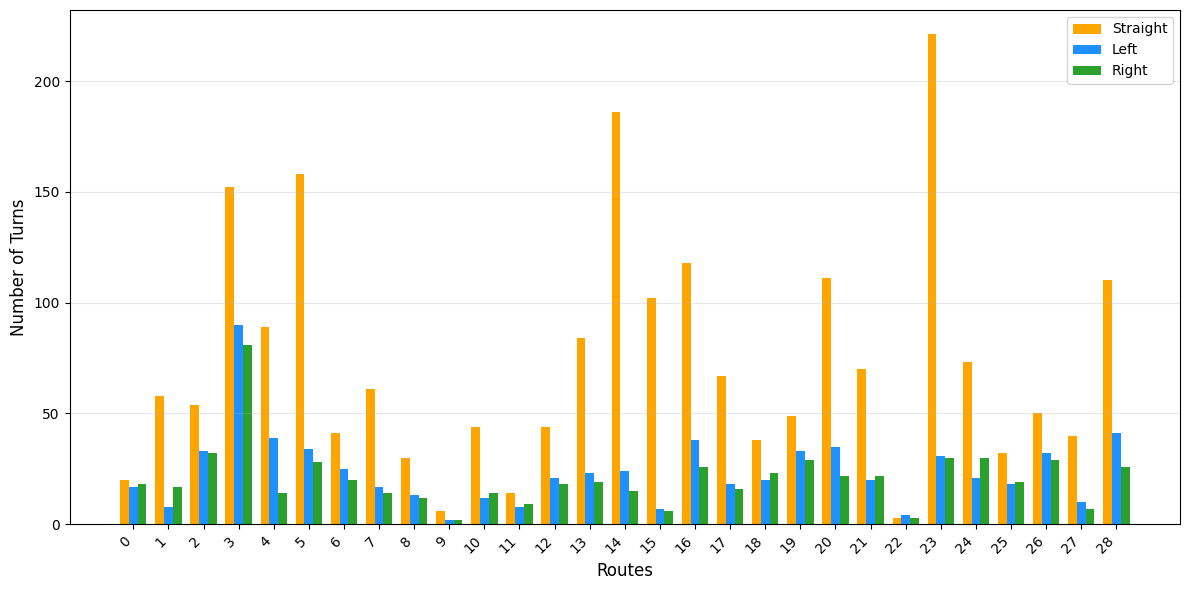


Processing: dave_krupski.parquet


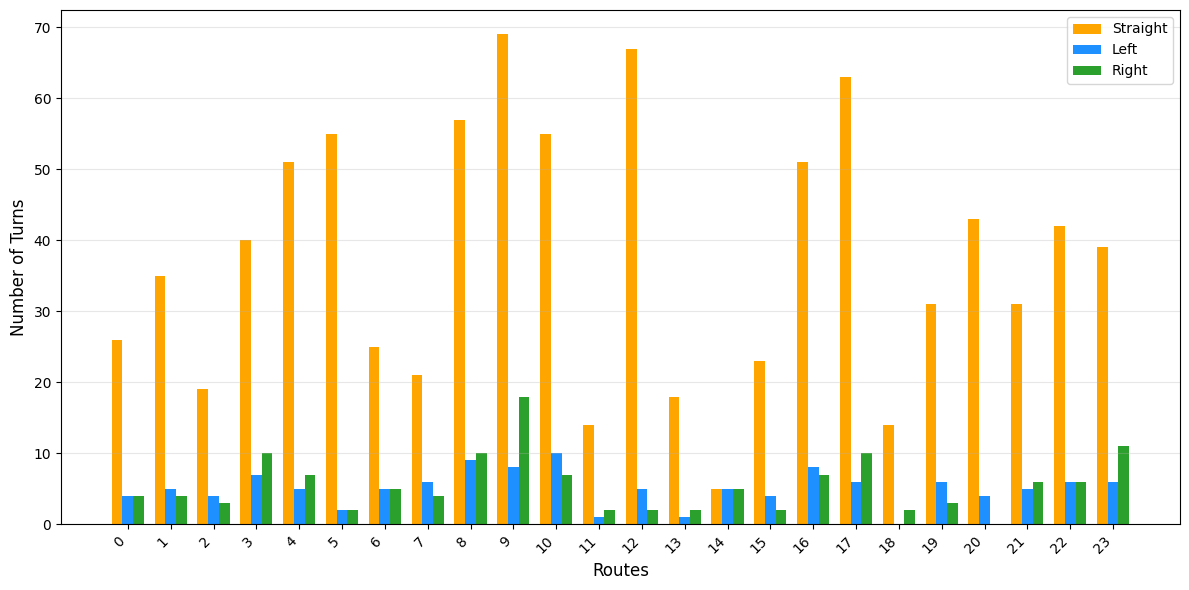


Processing: evgeny_arbatov.parquet


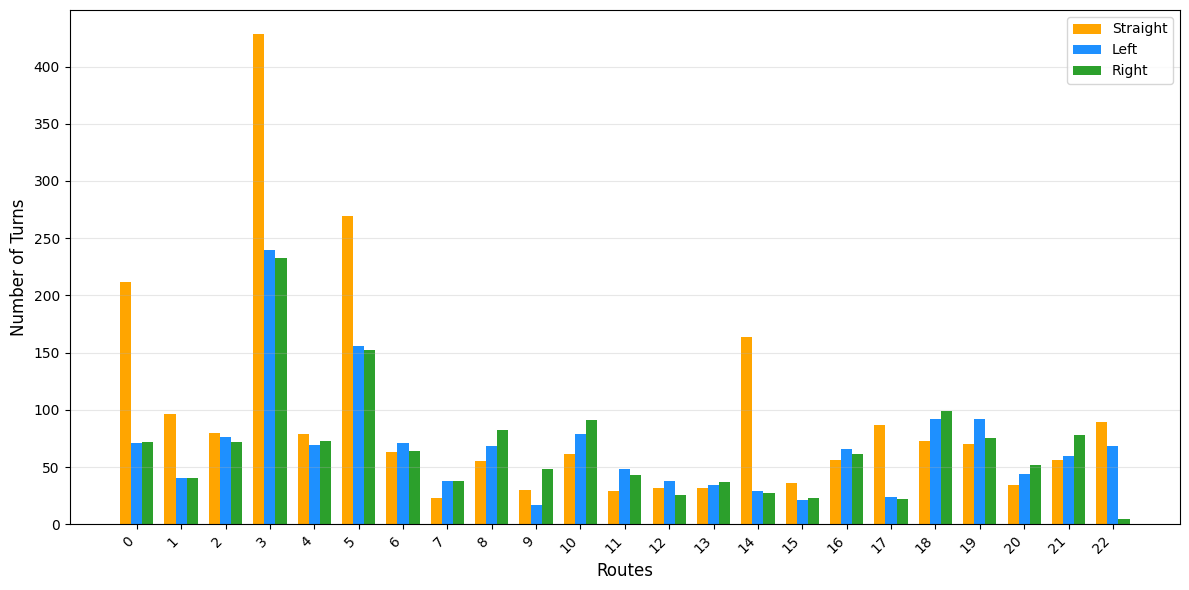


Processing: sean_richard.parquet


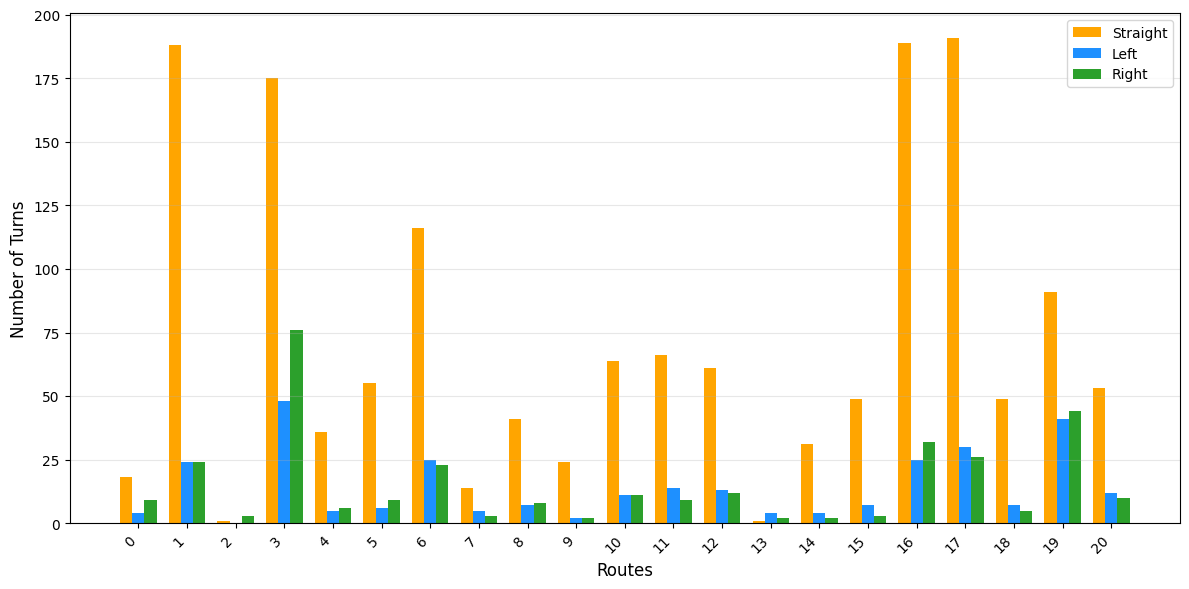


Processing: andreas_stemberger.parquet


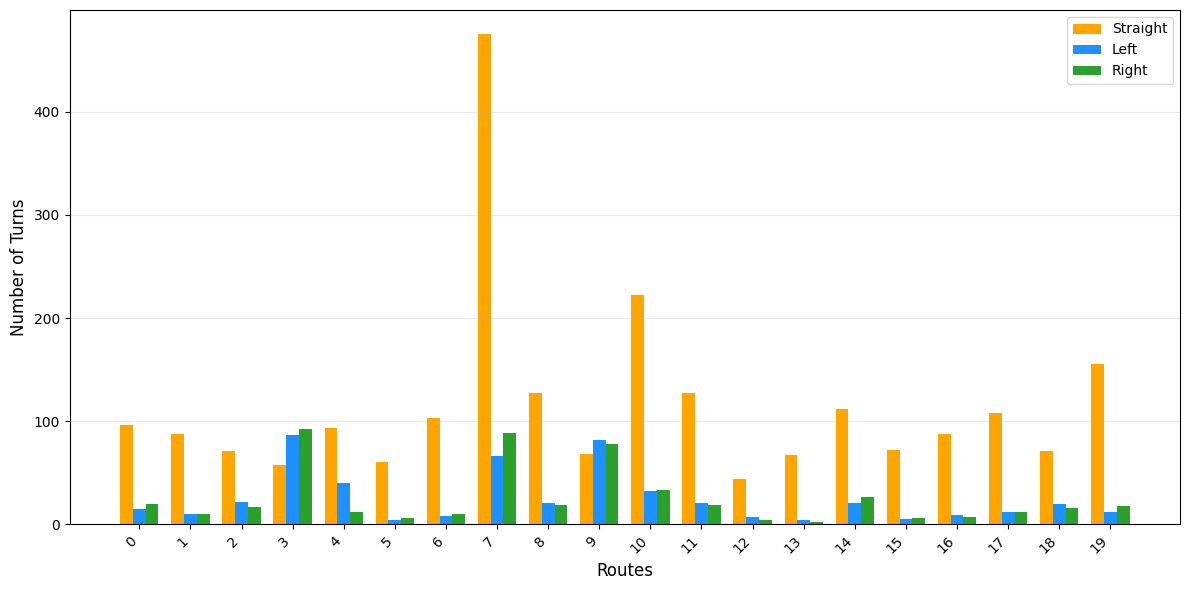


Processing: simen_holvik.parquet


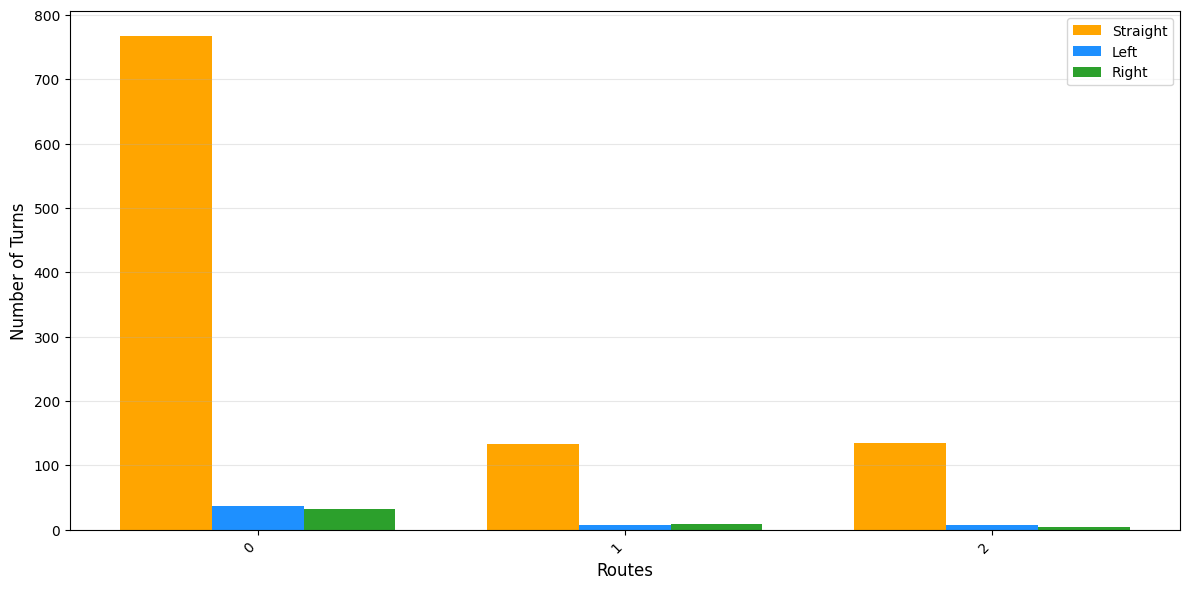


Processing: madoka_spence.parquet


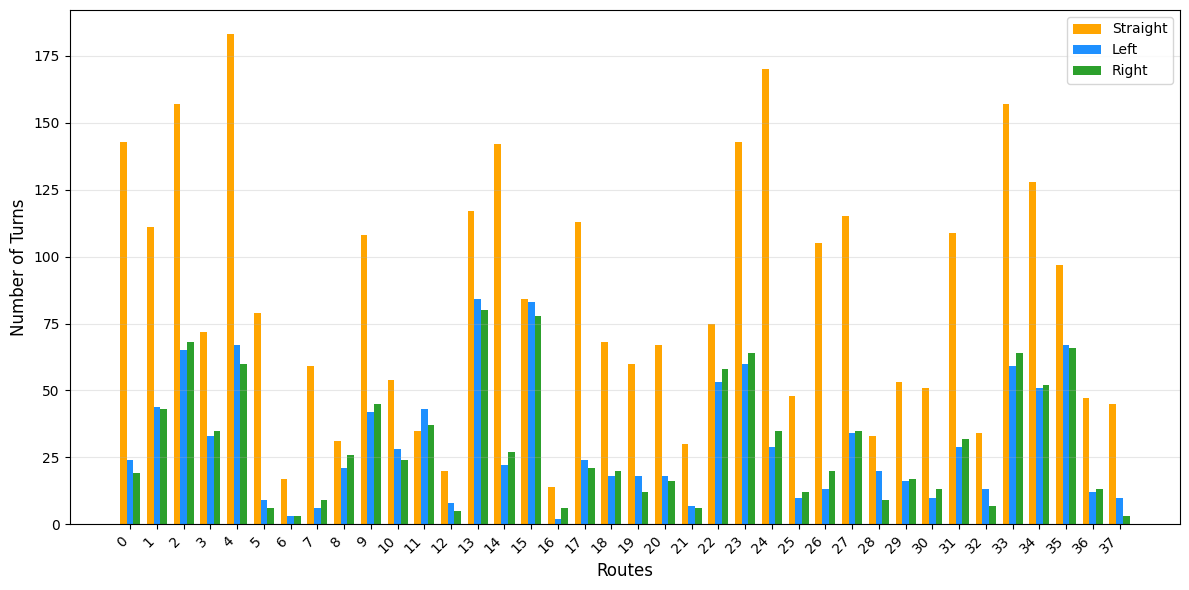


Processing: rebecca_oliver.parquet
No valid routes in rebecca_oliver.parquet

Processing: kevin_koncilja.parquet


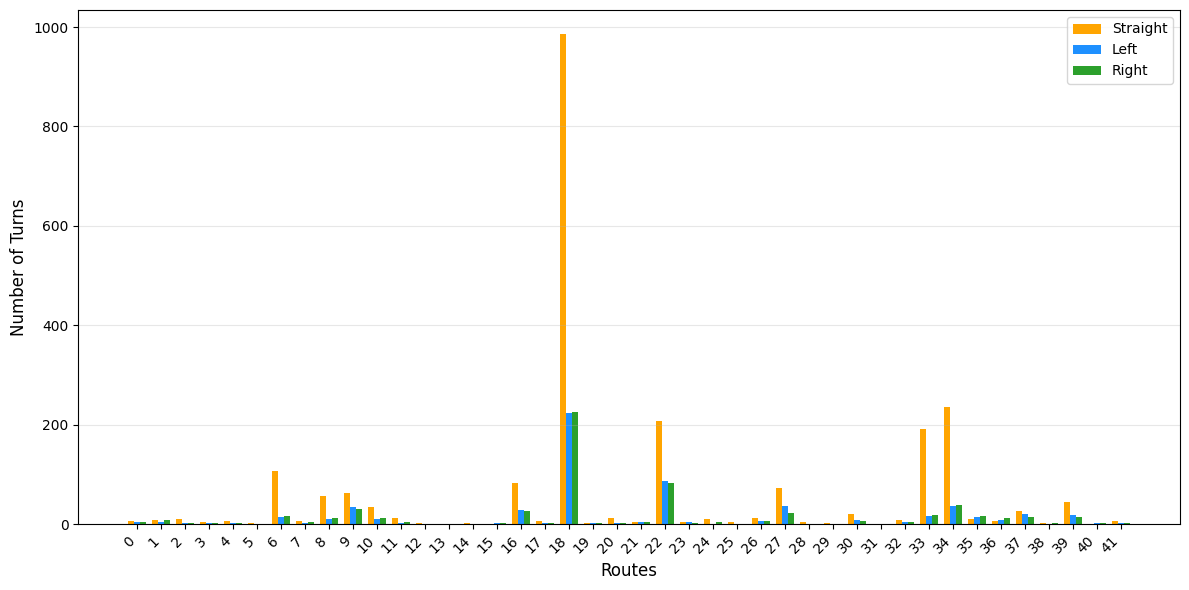


Processing: michael_postulka.parquet


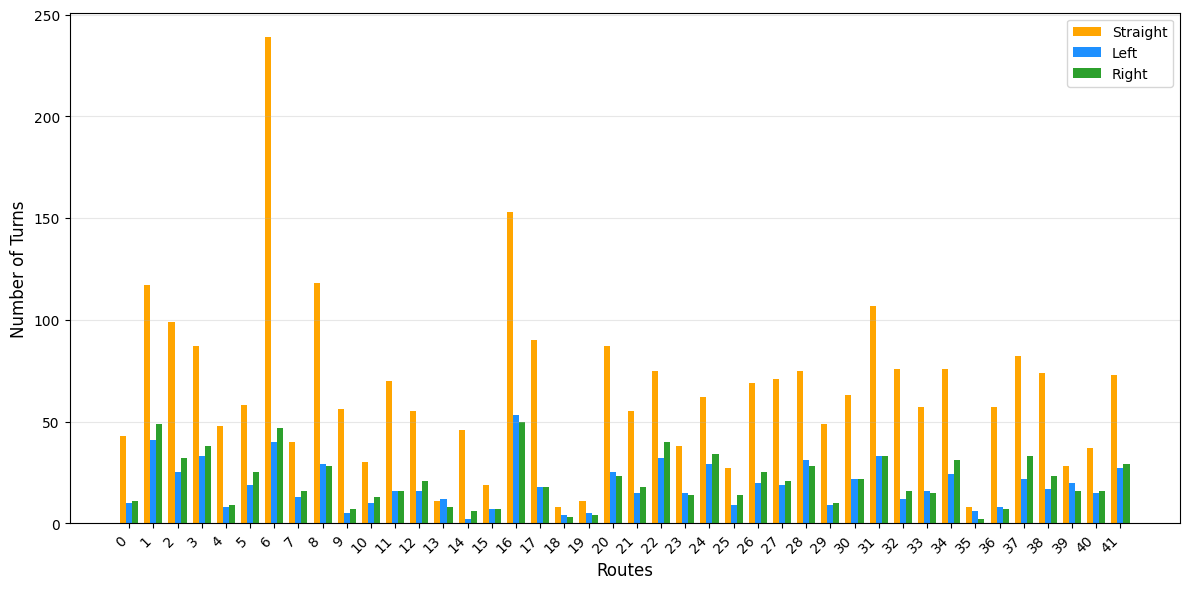


Processing: anonymous_participant.parquet


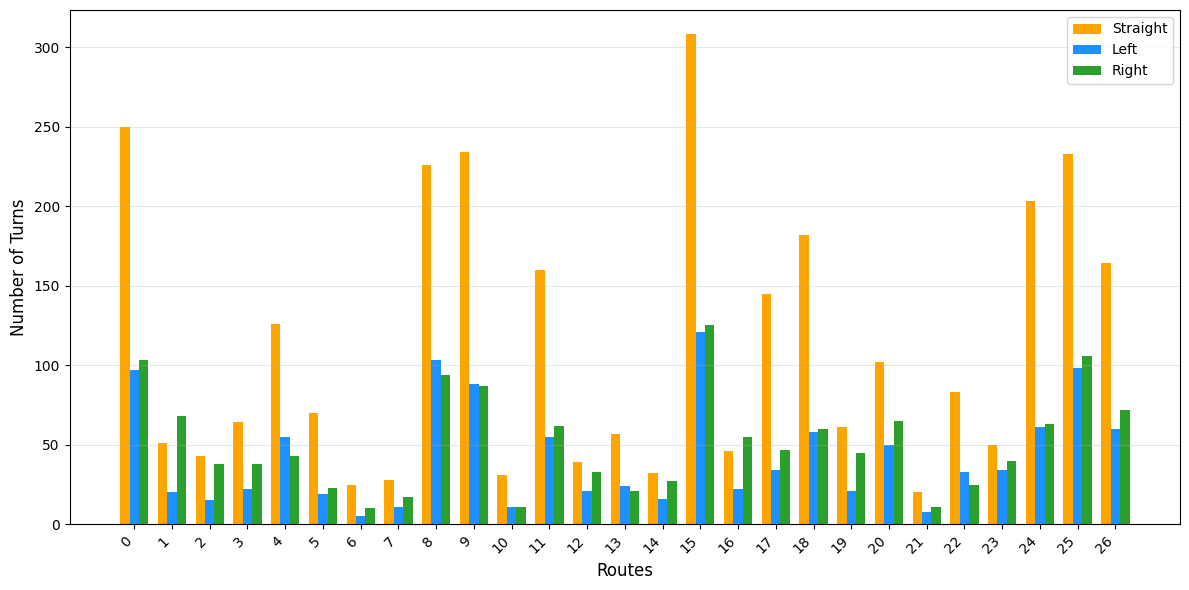


Processing: jessica_de_la_cruz.parquet


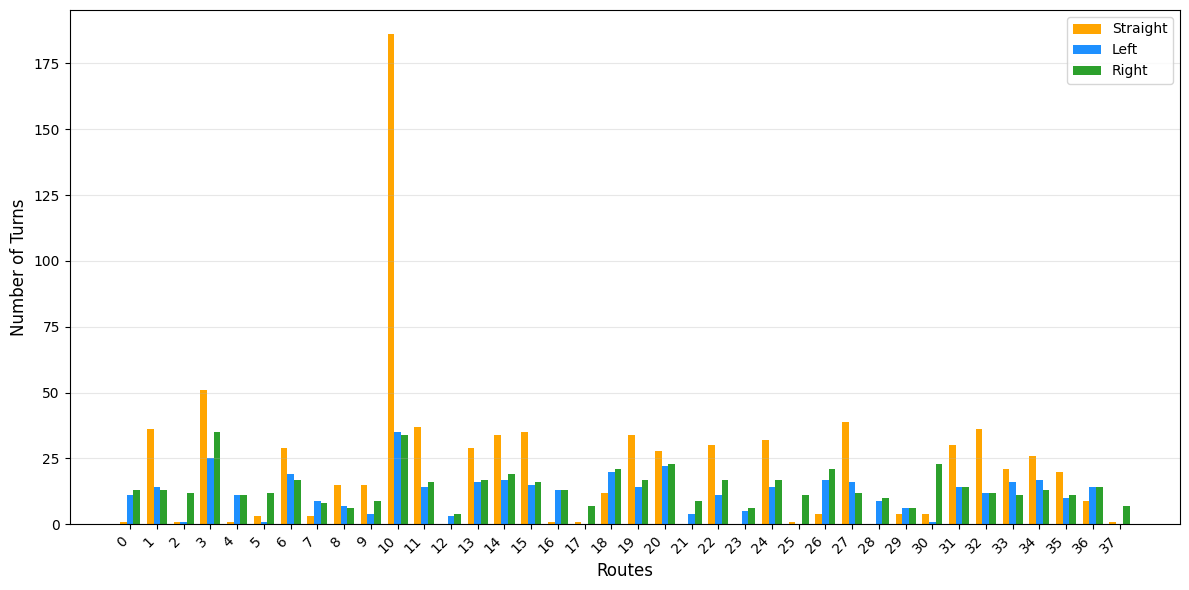


Processing: angela_hawley.parquet


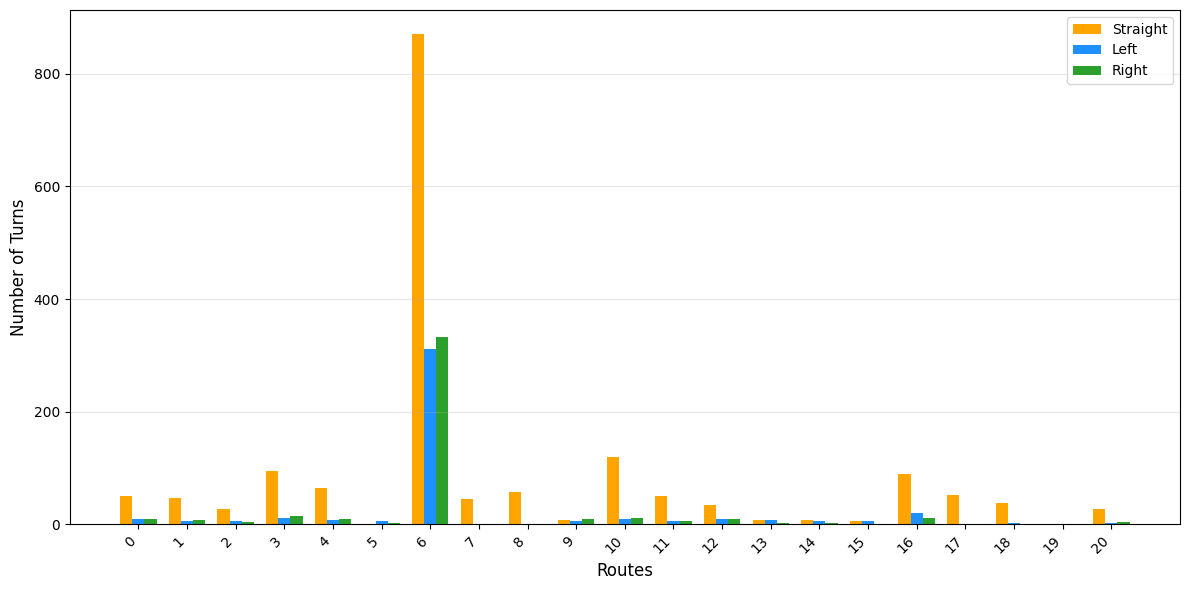


Processing: tim_walter_reudelsdorff.parquet


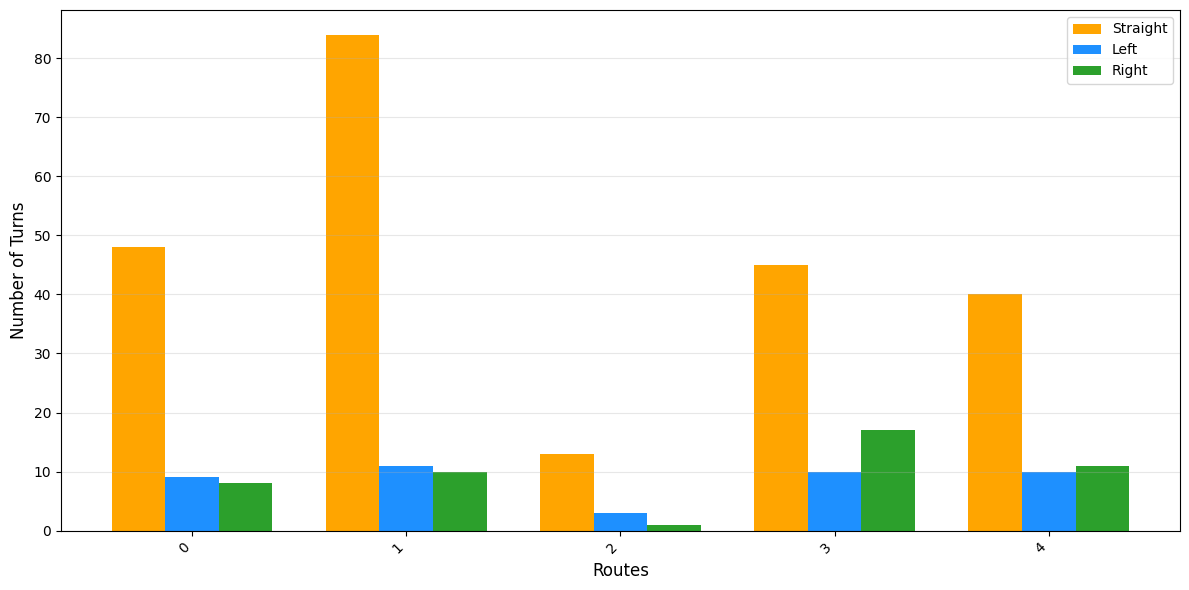


Processing: emily_lyons.parquet


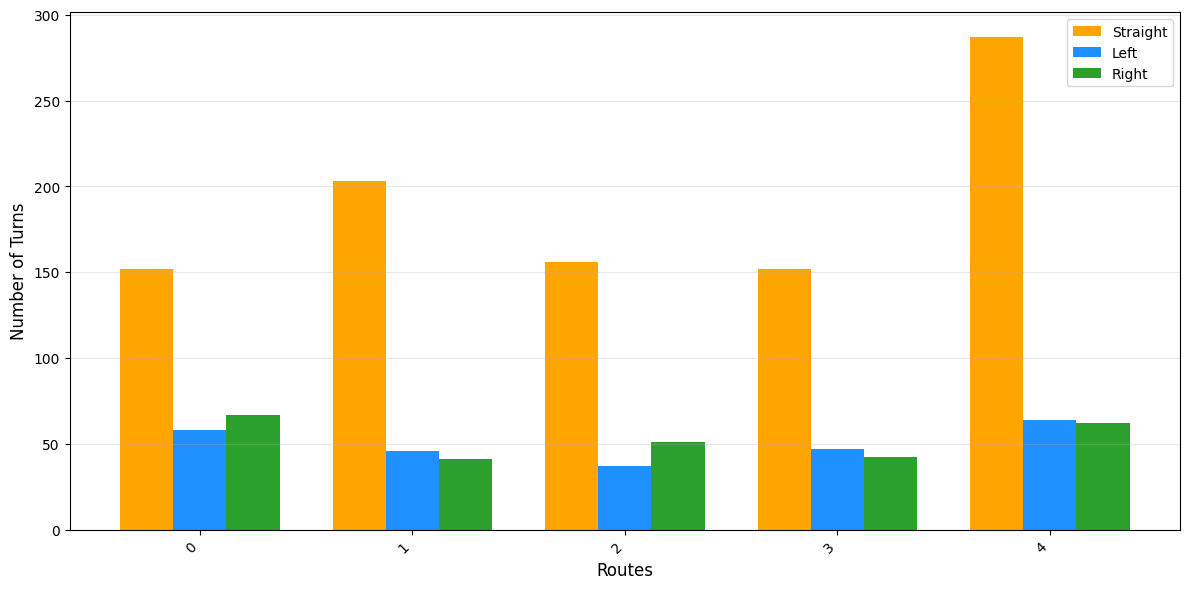


Processing: aner_cosme.parquet


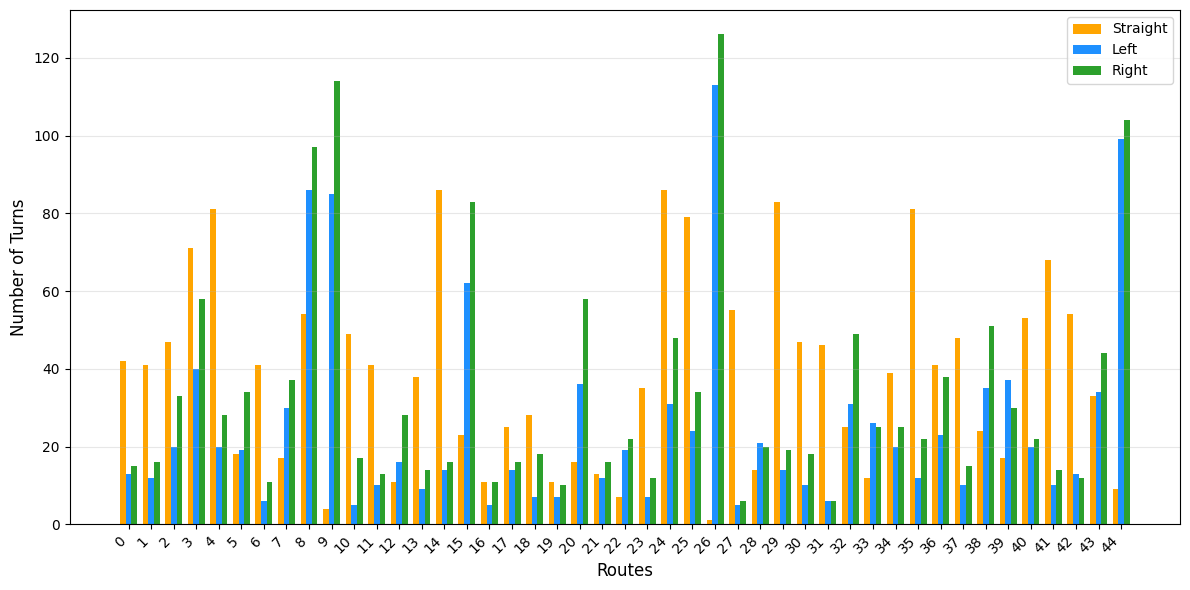


Processing: stephen_mick.parquet


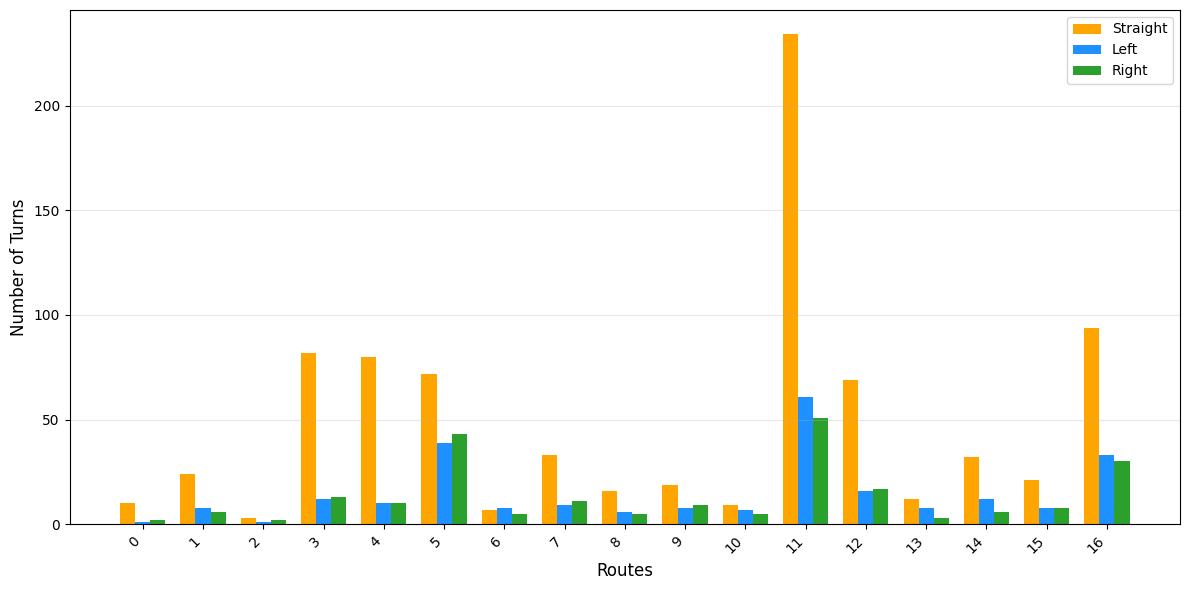


Processing: jeffrey_jordan.parquet


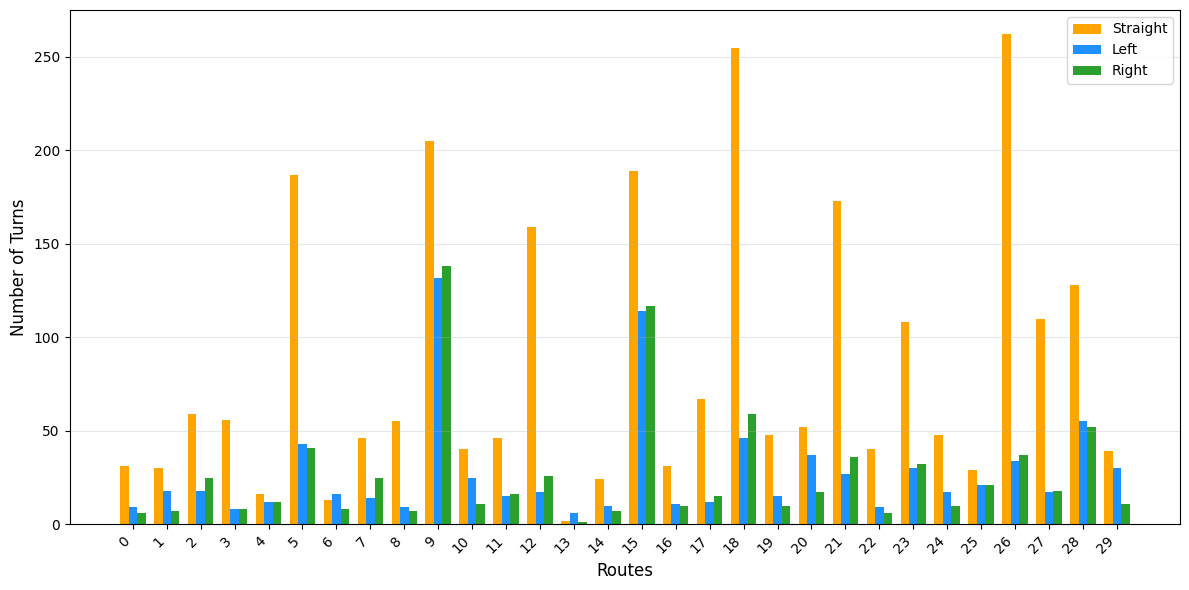


Processing: athanasia_tolidou.parquet


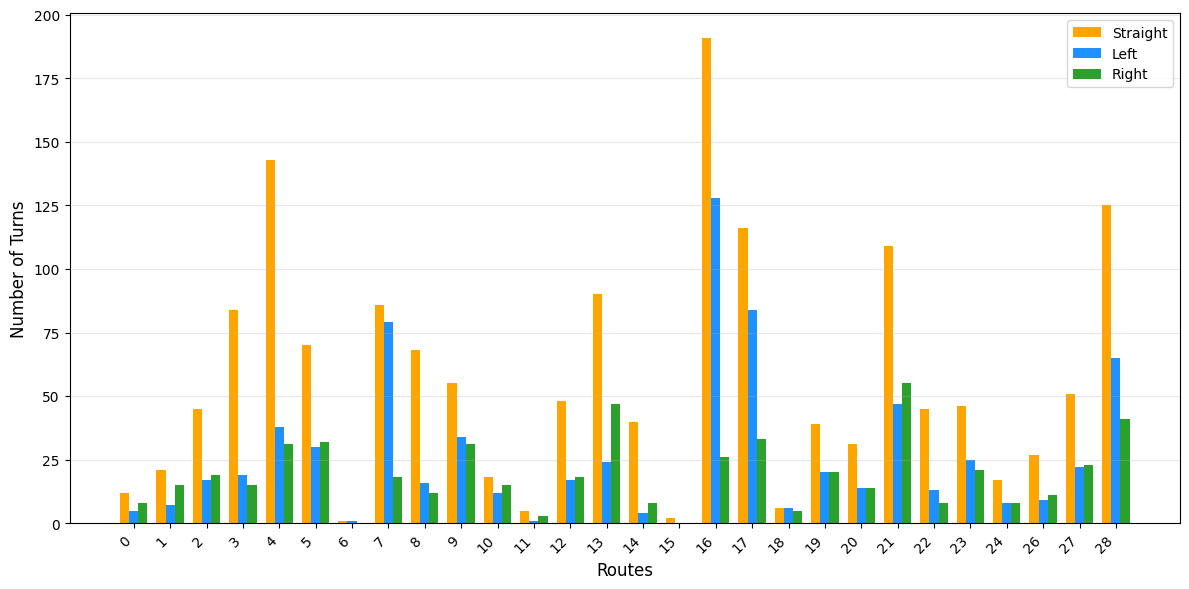


Processing: christian_nogens.parquet


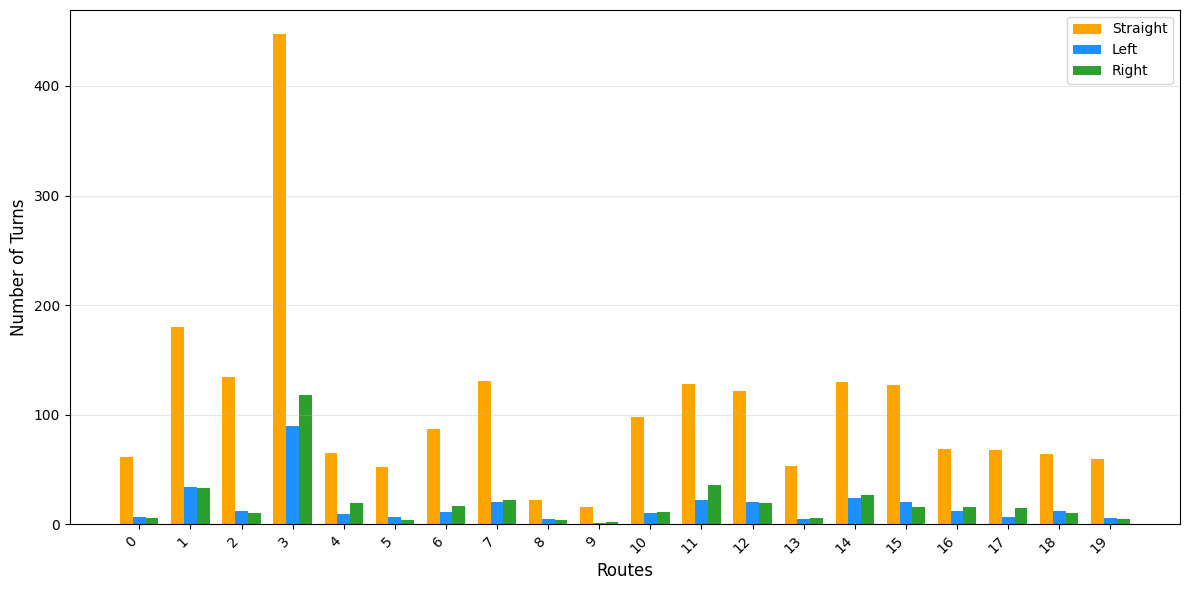


Processing: david_van_den_bossche.parquet


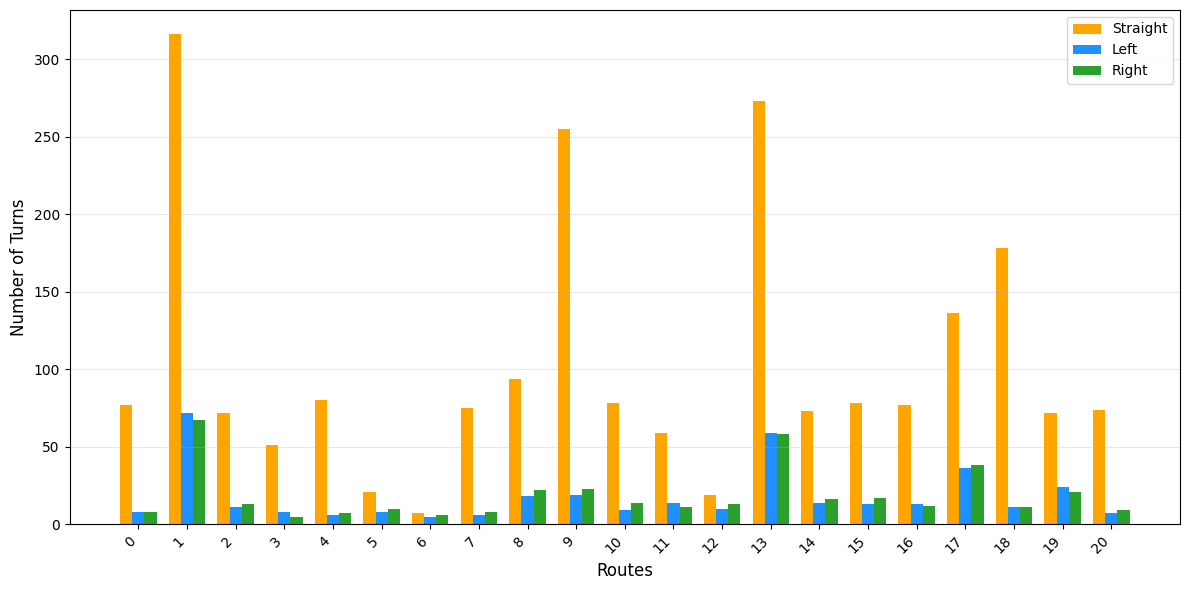

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from geopy.distance import geodesic
from math import atan2, degrees

# --- Configuration ---
content_dir = '/content'
parquet_files = [f for f in os.listdir(content_dir) if f.endswith('.parquet')]

# Colors
turn_colors = {
    "straight": "#FFA500",  # Orange
    "left": "#1E90FF",      # Light Blue
    "right": "#2CA02C"      # Green
}

# --- Helper functions ---
def extract_route_coordinates(geometry):
    if geometry is None or geometry.is_empty:
        return None
    return [(coord[1], coord[0]) for coord in geometry.coords]

def compute_azimuth(p1, p2):
    lat1, lon1 = np.radians(p1)
    lat2, lon2 = np.radians(p2)
    d_lon = lon2 - lon1
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)
    az = np.degrees(atan2(x, y))
    return (az + 360) % 360

def classify_turns(route, threshold=45):
    if route is None or len(route) < 3:
        return []
    turn_types = []
    for i in range(len(route) - 2):
        az1 = compute_azimuth(route[i], route[i+1])
        az2 = compute_azimuth(route[i+1], route[i+2])
        delta = (az2 - az1 + 180) % 360 - 180
        if abs(delta) <= threshold:
            turn_types.append("straight")
        elif delta > 0:
            turn_types.append("right")
        else:
            turn_types.append("left")
    return turn_types

# --- Process each parquet file ---
for parquet_file in parquet_files:
    print(f"\nProcessing: {parquet_file}")
    file_path = os.path.join(content_dir, parquet_file)
    gdf = gpd.read_parquet(file_path)

    all_turn_counts = []
    route_labels = []

    for idx, geom in enumerate(gdf.geometry):
        coords = extract_route_coordinates(geom)
        if coords is None or len(coords) < 3:
            continue

        turns = classify_turns(coords)
        turn_counts = [turns.count(t) for t in ["straight", "left", "right"]]
        all_turn_counts.append(turn_counts)
        route_labels.append(f"{idx}")

    if not all_turn_counts:
        print(f"No valid routes in {parquet_file}")
        continue

    # Convert to numpy array for easier plotting
    all_turn_counts = np.array(all_turn_counts)
    n_routes = all_turn_counts.shape[0]
    x = np.arange(n_routes)  # Route indices
    width = 0.25  # Bar width

    # --- Plot grouped bar chart ---
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, all_turn_counts[:, 0], width, color=turn_colors["straight"], label="Straight")
    plt.bar(x, all_turn_counts[:, 1], width, color=turn_colors["left"], label="Left")
    plt.bar(x + width, all_turn_counts[:, 2], width, color=turn_colors["right"], label="Right")

    plt.xlabel("Routes", fontsize=12)
    plt.ylabel("Number of Turns", fontsize=12)
    plt.xticks(x, route_labels, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"/content/turn_distribution_all_routes_{parquet_file[:-8]}.png", dpi=150)
    plt.show()
    plt.close()
